<a href="https://colab.research.google.com/github/leticiasdrummond/Notebooks_IT306/blob/main/3_PVlib_parte1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
Carlos Alberto Medon Dias Ferraz

Carlos Eduardo Bento Honorio

Letícia Sampaio Drummond Valladares  
</center>
    

---

<center>

# **PROJETO I - MODELO DRUMMOND**

<center>

<center>

## **Tema: Sistemas Fotovoltaicos On-Grid e Off-Grid**

<center>

---



Professores:

   Dr. João Lucas, Dr. Gustavo Fraidenraich e Dr. Tárcio Barros
   
Monitoria:

   Me. João Frederico

<center>
03 de Novembro de 2025
<center>

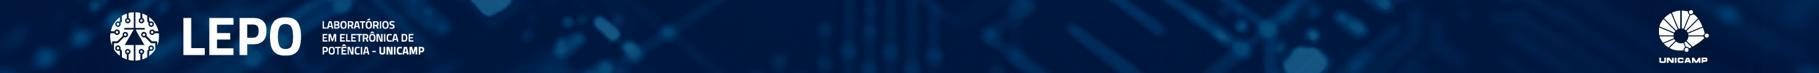

# **Introdução**

Este trabalho apresenta a modelagem de uma usina fotovoltaica (FV) utilizando a linguagem Python e a biblioteca PVlib. O objetivo principal é implementar uma cadeia completa de modelos físicos para simular a geração de energia FV, validando os resultados por meio de comparação com as simulações de referência realizadas no PVsyst.

A configuração da usina é padrão, instalação em solo, considerando um inversor com potência igual ou superior a 75 kW e um conjunto de módulos FV (monofaciais orientados para o sul), cuja potência total seja superior à do inversor. Não são consideradas as perdas por self-shading (sombreamento entre as strings).

A proposta contempla a análise de dados meteorológicos de diferentes anos, a aplicação de modelos físicos e matemáticos para estimativa da irradiância no plano dos módulos, o uso do modelo de diodo único (Single Diode Model – SDM) para cálculo da geração de energia, a consideração de perdas elétricas e térmicas e o desempenho do inversor.

Além disso, foi realizada uma simulação complementar de armazenamento em baterias LFP para avaliar a integração de sistemas híbridos. O trabalho busca não apenas reproduzir os resultados obtidos no PVsyst, mas também aprofundar a compreensão dos processos físicos envolvidos na conversão fotovoltaica.

Através do presente arquivo do notebook (.ipynb), apresentamos os códigos comentados, com descrições e títulos de seção antes de cada bloco de código.

---
---
# **Metodologia**

**Definição da Usina:**  

*   **Configuração Padrão**: Usina em solo, módulos monofaciais, orientação Sul (sem *self-shading*).
*  Inversor ≥75 kW e potência de módulo superior à do inversor.
*   Local: SOLRMAP University of Arizona (OASIS)
    
    - Latitude: 32.22969
    - Longitude: 110.95534
    - Elevação: 786 AMSL
    - Time Zone: MSTI


**Coleta de Dados Meteorológicos:** Aquisição de dados de satélite para 3 anos distintos (2019-2021), essenciais para o cálculo da irradiância.

**Modelagem em Python/PVlib:**

1.  Aplicação de modelos físicos para estimar a irradiância no plano dos módulos

2.  Cálculo da geração de energia usando o Modelo de Diodo Único (SDM)

3.  Consideração de perdas elétricas, desempenho do inversor e modelos de temperatura e céu claro (ClearSky)

4.   Análise e Comparação: Avaliação do desempenho da usina e comparação detalhada com os resultados simulados no PVsyst

5.   Análise de armazenamento em baterias LFP para explorar a integração de sistemas híbrido
`.





### **Referencias Utilizadas**
- https://assessingsolar.org/notebooks/quality_asessment.html#
- DMxxxM10RT-B60HBT/HST 490~510W

- Best Practices Handbook for the Collection and Use of Solar Resource Data for Solar Energy Applications: Fourth Edition (2024)
- Manual de Engenharia para Sistemas Fotovoltaicos (2014).

## **Instalação de bibliotecas**

In [ ]:
!pip install pvlib

In [ ]:
!pip install folium

# **Ferramentas do PVLib**


In [ ]:
# Importação das bibliotecas necessárias
import pvlib # Biblioteca para modelagem de energia solar fotovoltaica (FV)
from pvlib import location  # Módulo para definir localização geográfica
from pvlib import pvsystem
from pvlib import tools
from pvlib.pvsystem import retrieve_sam
import folium
import pandas as pd # Manipulação de dados em formato de tabela
import matplotlib.pyplot as plt # Plotagem de gráficos
from sklearn.metrics import r2_score
from scipy.constants import Boltzmann, elementary_charge
import numpy as np
from pvlib import irradiance
from pvlib.iam import physical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **1. Avaliação do Recurso Solar**
Para efeito de avaliação da qualidade do recurso solar, na regiao do Arizona (localidade da estação solarimétrica indicada para o projeto) e definição do Database metereológico a ser aplicado na modelagem fotovoltaica, foram escolhidos os dados de GHI, DHI, DNI disponíveis nas bases de dados de satélite da NSRDB e do PVGIS e da estação solarimétrica UAT - OASIS/Arizona, para os anos de 2019, 2020 e 2021.
As medições, originalmente fornecidas em bases horária ou em minuto, foram adequadas para séries diárias para possibilitar a comparação entre elas.

## **1.1 Localização de Referência da Usina Fotovoltaica**
Para este trabalho, foi considerada a seguinte localização geográfica:

| **Parâmetro**       | **Valor**               | **Descrição**                          |
|----------------------|-------------------------|----------------------------------------|
| **Nome da Estação**    | UAT	SOLRMAP University of Arizona (OASIS)	        | Estação operada pelo NREL  Measurement and Instrumentation Data Center (MIDC)            |
| **Latitude**         |32.22969            | Coordenada geográfica                  |
| **Longitude**        | -110.95534            | Coordenada geográfica                  |
| **Altitude**         | 786 metros             | Elevação em relação ao nível do mar    |
| ***Time Zone***         | MST             | *Mountain Standard Time (MST) is 7 hours behind Coordinated Universal Time (UTC). This time zone is in use during standard time in: North America. *|

FONTE:
Andreas, A.; Wilcox, S.; (2010). Observed Atmospheric and Solar Information
System (OASIS); Tucson, Arizona (2025); NREL Report No. DA-5500-56494.
http://dx.doi.org/10.5439/1052226


*   **Mapa de Referência**




In [ ]:
# @title
## Mapa de Referência
# Coordenadas geográficas (latitude, longitude, altitude) de UAT
latitude = 32.22969
longitude = -110.95534
altitude = 786  # em metros


# Criar um mapa interativo centralizado na localização
mapa = folium.Map(
    location=[latitude, longitude],
    zoom_start=12,
    tiles='OpenStreetMap'  # Tipo de mapa
)

# Adicionar um marcador no mapa
folium.Marker(
    [latitude, longitude],
    popup="Localização selecionada: SOLRMAP University of Arizona (OASIS) (UAT)",
    icon=folium.Icon(color='green', icon='info-sign')
).add_to(mapa)

# Exibir o mapa
mapa

## **1.2 Características Relevantes da Região de Tucson**


    - Alta disponibilidade solar, com valor médio superior a 300 dias de sol/ano;
    - Região é um dos melhores locais dos EUA para geração FV;
    - Temperaturas elevadas no verão, com a atenção para a modelagem térmica na determinação das perdas;
    - Baixa nebulosidade, ideal para uso de modelos de céu claro (Haurwitz, Ineichen);
    - Clima desértico quente e seco, com ventos leves e poucas chuvas, cenário ideal para simulações de alto desempenho FV, mas requer controle de poeira.

## **1.3 Funcao da Posição Solar**

> Permite localizar a posição do sol em relação ao módulo na localidade do projeto.



In [ ]:
Latitude = 32.22969
Longitude = -110.95534
Altitude = 786
tz= 'Etc/GMT-7'

> Vale observar que usaremos a funcao do solar.position para o calculo da irradiacao incidente no módulo (Ver item 2.2)





---



## **1.4 Parâmetros Climáticos Iniciais para a Modelagem**
Para o início da modelagem foram utilizadas as seguintes variáveis metereológicas:

**Irradiação Solar**
   - GHI (Irradiância Global Horizontal) [W/m²]
   - DNI (Irradiância Direta Normal) [W/m²]
   - DHI (Irradiância Difusa Horizontal) [W/m²]

**Variáveis Ambientais**
   - Temperatura do Ar [°C]
   - Velocidade do Vento [m/s]

Para os anos 2019, 2020 e 2021, essas variáveis meteorológicas, em séries horárias (1h), foram extraidas nas bases de dados da NSRDB (NSRDB PSMv4), PVGIS (PVGIS 5.3 ERA 5) e dados medidos in loco da University of Arizona (OASIS)	Estaçao "UAT" operada pelo NREL Measurement and Instrumentation Data Center (MIDC):



## **1.5 Definicao do Database Metereológico**
A definição do Database metereológico a ser utilizado na modelagem da usina FV, foi baseada nos dados de GHI do perído de 2019 a 2021, extraídos dos dois satélites, os quais foram comparados com os dados medidos pela estação UAT, no mesmo período. A escolha do Databse metereológico, ou do satélite foi baseada em análises estatística dos parâmetros RMSE, MAE e R2.

### **1.5.1 NSRDB**

Os códigos a seguir consistem na importação dos dados horários para os anos de 2019, 2020 e 2021. Após a essa importação, os valores com discretização horária foram reajustados para escala diária.

In [ ]:
latitude = 32.22969   # Tucson, Arizona, EUA
longitude = -110.95534  # Tucson, Arizona, EUA
email = 'l298985@dac.unicamp.br'
api_key = 'UdBqiBH0jDG1heMhlE7sDhZSnJiDETFaPefAH7m4'
year_2019 = 2019
year_2020 = 2020
year_2021 = 2021

data_nsrdb_2019, meta_nsrdb = pvlib.iotools.get_nsrdb_psm4_full_disc(latitude,longitude, api_key, email, year_2019, time_step=60, parameters=('air_temperature', 'dew_point', 'dhi', 'dni', 'ghi', 'surface_albedo', 'surface_pressure', 'wind_direction', 'wind_speed'), leap_day=True, full_name='pvlib python', affiliation='pvlib python', utc=True, map_variables=True, url=None, timeout=60)


data_nsrdb_2020, meta_nsrdb = pvlib.iotools.get_nsrdb_psm4_full_disc(latitude,longitude, api_key, email, year_2020, time_step=60, parameters=('air_temperature', 'dew_point', 'dhi', 'dni', 'ghi', 'surface_albedo', 'surface_pressure', 'wind_direction', 'wind_speed'), leap_day=True, full_name='pvlib python', affiliation='pvlib python', utc=True, map_variables=True, url=None, timeout=60)


data_nsrdb_2021, meta_nsrdb = pvlib.iotools.get_nsrdb_psm4_full_disc(latitude,longitude, api_key, email, year_2021, time_step=60, parameters=('air_temperature', 'dew_point', 'dhi', 'dni', 'ghi', 'surface_albedo', 'surface_pressure', 'wind_direction', 'wind_speed'), leap_day=True, full_name='pvlib python', affiliation='pvlib python', utc=True, map_variables=True, url=None, timeout=60)

print(data_nsrdb_2019)
print(data_nsrdb_2020)
print(data_nsrdb_2021)

In [ ]:
print(data_nsrdb_2019['ghi'].resample('D').sum())
print(data_nsrdb_2020['ghi'].resample('D').sum())
print(data_nsrdb_2021['ghi'].resample('D').sum())

In [ ]:
nsrdb_data_3Y = nsrdb_data_3Y = pd.concat([data_nsrdb_2019, data_nsrdb_2020, data_nsrdb_2021], axis=0)
nsrdb_data_3Y
# Kt x Diffuse Fraction


dni_extra = pvlib.irradiance.get_extra_radiation(nsrdb_data_3Y.index)



Kt = nsrdb_data_3Y['ghi']/dni_extra

diff_fraction = nsrdb_data_3Y['dhi']/nsrdb_data_3Y['ghi']

plt.scatter(Kt, diff_fraction)
plt.ylim(0, 1)
plt.xlabel('Kt (GHI/Io)')
plt.ylabel('Fração Difusa (DHI/GHI)')
plt.show()

### **1.5.2 PVGIS**
Os códigos a seguir foram importados do PVGIS. Vale esclarecer que "POA Global" é equivalente ao GHI quando tratamos da incidência sobre a superfície com inclinacao nula.







**2019**

In [ ]:
import pvlib
from pvlib.iotools import get_pvgis_hourly
import pandas as pd

# Dados fornecidos
latitude = 32.22969
longitude = -110.95534
altitude = 786
tz = 'Etc/GMT-7'

# Obter dados horários do PVGIS usando ERA5
try:
    data = get_pvgis_hourly(
        latitude=latitude,
        longitude=longitude,
        start=2019,  # inicia em jan.
        end=2019,    # termina em dez.
        raddatabase='PVGIS-ERA5',  # Base de dados ERA5
        components=False,     # Retorna componentes de radiação
        surface_tilt=0,      # Superfície horizontal
        surface_azimuth=0,   # Orientação para sul
        outputformat='json',
        usehorizon=True,     # Considera horizonte
        userhorizon=None,    # Sem horizonte personalizado
        pvcalculation=False, # Apenas dados meteorológicos
        timeout=60
    )

    # Extrair os dados
    df = data[0]  # DataFrame com os dados horários
    metadata = data[1]  # Metadados

    print("Dados obtidos com sucesso!")
    print(f"Localização: {latitude}, {longitude}")
    print(f"Altitude: {altitude} m")
    print(f"Fuso horário: {tz}")
    print(f"Período dos dados: {df.index[0]} até {df.index[-1]}")
    print("\nPrimeiras linhas dos dados:")
    print(df.head())

    print("\nColunas disponíveis:")
    for col in df.columns:
        print(f"- {col}")

    print("\nMetadados:")
    for key, value in metadata.items():
        print(f"{key}: {value}")

except Exception as e:
    print(f"Erro ao obter dados: {e}")

**2020**

In [ ]:
import pvlib
from pvlib.iotools import get_pvgis_hourly
import pandas as pd

# Dados fornecidos
latitude = 32.22969
longitude = -110.95534
altitude = 786
tz = 'Etc/GMT-7'

# Obter dados horários do PVGIS usando ERA5
try:
    data_20 = get_pvgis_hourly(
        latitude=latitude,
        longitude=longitude,
        start=2020,  # Usará data padrão se None
        end=2020,    # Usará data padrão se None
        raddatabase='PVGIS-ERA5',  # Base de dados ERA5
        components=False,     # Retorna componentes de radiação
        surface_tilt=0,      # Superfície horizontal
        surface_azimuth=0,   # Orientação para sul
        outputformat='json',
        usehorizon=True,     # Considera horizonte
        userhorizon=None,    # Sem horizonte personalizado
        pvcalculation=False, # Apenas dados meteorológicos
        timeout=60
    )

    # Extrair os dados
    df_2020 = data_20[0]  # DataFrame com os dados horários
    metadata = data_20[1]  # Metadados

    # Rename the 'poa_global' column to 'poa_global_2020'
    df_2020 = df_2020.rename(columns={'poa_global': 'poa_global_2020'})

    print("Dados obtidos com sucesso!")
    print(f"Localização: {latitude}, {longitude}")
    print(f"Altitude: {altitude} m")
    print(f"Fuso horário: {tz}")
    print(f"Período dos dados: {df_2020.index[0]} até {df_2020.index[-1]}")
    print("\nPrimeiras linhas dos dados:")
    display(df_2020.head())

    print("\nColunas disponíveis:")
    for col in df_2020.columns:
        print(f"- {col}")

    print("\nMetadados:")
    for key, value in metadata.items():
        print(f"{key}: {value}")

except Exception as e:
    print(f"Erro ao obter dados: {e}")

**2021**

In [ ]:
import pvlib
from pvlib.iotools import get_pvgis_hourly
import pandas as pd

# Dados fornecidos
latitude = 32.22969
longitude = -110.95534
altitude = 786
tz = 'Etc/GMT-7'

# Obter dados horários do PVGIS usando ERA5
try:
    data = get_pvgis_hourly(
        latitude=latitude,
        longitude=longitude,
        start=2021,  # Usará data padrão se None
        end=2021,    # Usará data padrão se None
        raddatabase='PVGIS-ERA5',  # Base de dados ERA5
        components=False,     # Retorna componentes de radiação
        surface_tilt=0,      # Superfície horizontal
        surface_azimuth=0,   # Orientação para sul
        outputformat='json',
        usehorizon=True,     # Considera horizonte
        userhorizon=None,    # Sem horizonte personalizado
        pvcalculation=False, # Apenas dados meteorológicos
        timeout=60
    )

    # Extrair os dados
    df_2021 = data[0]  # DataFrame com os dados horários
    metadata = data[1]  # Metadados

    # Rename the 'poa_global' column to 'poa_global_2021'
    df_2021 = df_2021.rename(columns={'poa_global': 'poa_global_2021'})

    print("Dados obtidos com sucesso!")
    print(f"Localização: {latitude}, {longitude}")
    print(f"Altitude: {altitude} m")
    print(f"Fuso horário: {tz}")
    print(f"Período dos dados: {df_2021.index[0]} até {df_2021.index[-1]}")
    print("\nPrimeiras linhas dos dados:")
    print(df_2021.head())

    print("\nColunas disponíveis:")
    for col in df_2021.columns:
        print(f"- {col}")

    print("\nMetadados:")
    for key, value in metadata.items():
        print(f"{key}: {value}")

except Exception as e:
    print(f"Erro ao obter dados: {e}")

### **1.5.3 Dados de Estação UAT-OASIS**

Os dados medidos in loco são fundamentais para garantir uma escolha correta do satélite a ser utilizado na modelagem da usina FV.

**2019**

* **Medições Locais UAT**

In [147]:
#Importando os Dados da Estação Solarimátrica
#Localização da Universidade de Arizona (OASIS)

df_weather = pvlib.iotools.read_midc_raw_data_from_nrel('UAT',               # Station id
                                                    pd.Timestamp('20190101'),   # Start date jan 2019
                                                    pd.Timestamp('20191231'))   # End date dez 2019

# Rename columns to match expected names (Renomeia as colunas pela combinação esperada para melhor organização)
df_weather = df_weather.rename(columns={
    'Air Temperature [deg C]': 'temp_air',
    'Avg Wind Speed @ 3m [m/s]': 'wind_speed',
    'Diffuse Horiz [W/m^2]': 'dhi',
    'Direct Normal [W/m^2]': 'dni',
    'Global Horiz (platform) [W/m^2]': 'ghi'
})


df_weather.head(3)

,Unnamed: 0,Year,DOY,MST,dni,dhi,Global Horiz (tracker) [W/m^2],ghi,Temp CHP1 [deg C],Temp CM22 (tracker) [deg C],...,CR1000 Temp [deg C],CR1000 Battery [VDC],temp_air,Rel Humidity [%],Station Pressure [mBar],wind_speed,Avg Wind Direction @ 3m [deg from N],Peak Wind Speed @ 3m [m/s],Zenith Angle [degrees],Azimuth Angle [degrees]
2019-01-01 00:00:00-07:00,0,2019,1,0,-0.43,0.00,-1.04,-1.37,-246.80,-246.80,...,7.49,13.53,3.89,87.90,923.39,5.60,115.00,6.95,NaN,NaN
2019-01-01 00:01:00-07:00,0,2019,1,1,-0.29,0.00,-1.11,-1.37,-246.80,-246.80,...,7.49,13.53,3.85,87.90,923.40,6.17,113.90,7.70,NaN,NaN
2019-01-01 00:02:00-07:00,0,2019,1,2,-0.39,0.00,-1.11,-1.37,-246.80,-246.80,...,7.49,13.53,3.84,87.90,923.40,6.91,117.50,8.45,NaN,NaN


* **Mudanca da escala temporal**








In [148]:
df_weather_ghi_horario_2019 = df_weather['ghi'].resample("H").mean()

/tmp/ipython-input-925422252.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_weather_ghi_horario_2019 = df_weather['ghi'].resample("H").mean()


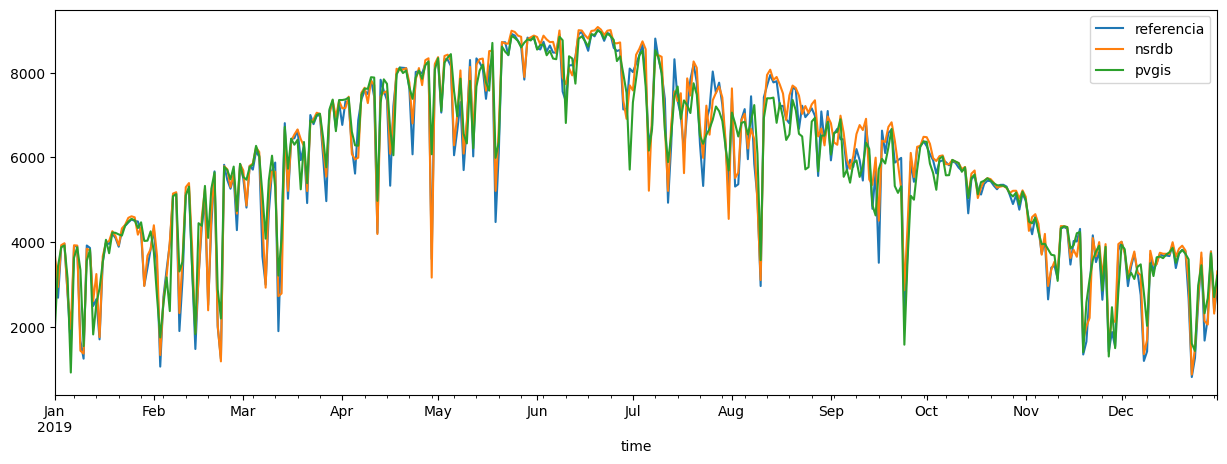

In [149]:
df_weather_ghi_horario_2019.resample("D").sum().plot(label ='referencia', figsize=(15,5))
data_nsrdb_2019['ghi'].resample('D').sum().plot(label ='nsrdb', figsize=(15,5))
df['poa_global'].resample('D').sum().plot(label ='pvgis', figsize=(15,5))
plt.legend()

**2020**

* **Medições Locais UAT**

In [150]:
#Importando os Dados da Estação Solarimátrica
#Localização da Universidade de Arizona (OASIS)

df_weather_2020 = pvlib.iotools.read_midc_raw_data_from_nrel('UAT',               # Station id
                                                    pd.Timestamp('20200101'),   # Start date jan 2020
                                                    pd.Timestamp('20201231'))   # End date dez 2020

# Rename columns to match expected names
df_weather_2020 = df_weather_2020.rename(columns={
    'Air Temperature [deg C]': 'temp_air',
    'Avg Wind Speed @ 3m [m/s]': 'wind_speed',
    'Diffuse Horiz [W/m^2]': 'dhi',
    'Direct Normal [W/m^2]': 'dni',
    'Global Horiz (platform) [W/m^2]': 'ghi'
})


df_weather_2020.head(3)

,Unnamed: 0,Year,DOY,MST,dni,dhi,Global Horiz (tracker) [W/m^2],ghi,Temp CHP1 [deg C],Temp CM22 (tracker) [deg C],...,CR1000 Temp [deg C],CR1000 Battery [VDC],temp_air,Rel Humidity [%],Station Pressure [mBar],wind_speed,Avg Wind Direction @ 3m [deg from N],Peak Wind Speed @ 3m [m/s],Zenith Angle [degrees],Azimuth Angle [degrees]
2020-01-01 00:00:00-07:00,0,2020,1,0,-0.43,0.00,-1.85,-2.14,-7999.00,-7999.00,...,11.05,13.51,8.29,61.38,927.43,1.07,95.90,1.70,NaN,NaN
2020-01-01 00:01:00-07:00,0,2020,1,1,-0.43,0.00,-1.85,-2.06,-7999.00,-7999.00,...,11.03,13.51,8.28,61.21,927.42,1.18,98.10,1.70,NaN,NaN
2020-01-01 00:02:00-07:00,0,2020,1,2,-0.43,0.00,-1.85,-2.26,-7999.00,-7999.00,...,11.01,13.51,8.26,61.36,927.43,1.19,87.60,1.70,NaN,NaN


* **Mudanca da escala temporal**

In [151]:
df_weather_ghi_horario_2020 = df_weather_2020['ghi'].resample("H").mean()

/tmp/ipython-input-882358708.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_weather_ghi_horario_2020 = df_weather_2020['ghi'].resample("H").mean()


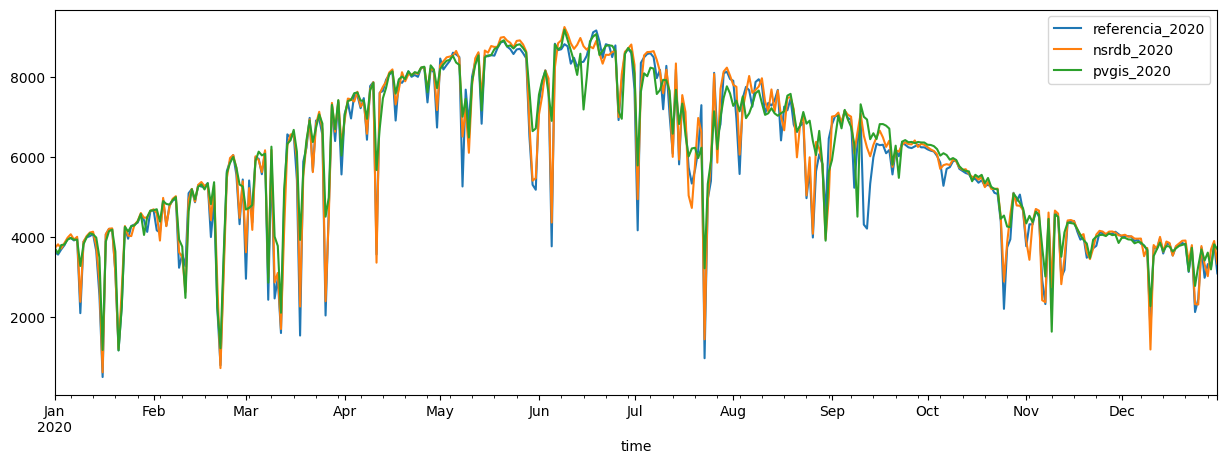

In [152]:
df_weather_ghi_horario_2020.resample("D").sum().plot(label ='referencia_2020', figsize=(15,5))
data_nsrdb_2020['ghi'].resample('D').sum().plot(label ='nsrdb_2020', figsize=(15,5))
df_2020['poa_global_2020'].resample('D').sum().plot(label ='pvgis_2020', figsize=(15,5))
plt.legend()

**2021**

 * **MEDICOES LOCAIS UAT**

In [153]:
#Importando os Dados da Estação Solarimátrica
#Localização da Universidade de Arizona (OASIS)

df_weather_2021 = pvlib.iotools.read_midc_raw_data_from_nrel('UAT',               # Station id
                                                    pd.Timestamp('20210101'),   # Start date jan 2021
                                                    pd.Timestamp('20211231'))   # End date dez 2021

# Rename columns to match expected names
df_weather_2021 = df_weather_2021.rename(columns={
    'Air Temperature [deg C]': 'temp_air',
    'Avg Wind Speed @ 3m [m/s]': 'wind_speed',
    'Diffuse Horiz [W/m^2]': 'dhi',
    'Direct Normal [W/m^2]': 'dni',
    'Global Horiz (platform) [W/m^2]': 'ghi'
})


df_weather_2021.head(3)

,Unnamed: 0,Year,DOY,MST,dni,dhi,Global Horiz (tracker) [W/m^2],ghi,Temp CHP1 [deg C],Temp CM22 (tracker) [deg C],...,CR1000 Temp [deg C],CR1000 Battery [VDC],temp_air,Rel Humidity [%],Station Pressure [mBar],wind_speed,Avg Wind Direction @ 3m [deg from N],Peak Wind Speed @ 3m [m/s],Zenith Angle [degrees],Azimuth Angle [degrees]
2021-01-01 00:00:00-07:00,0,2021,1,0,-0.38,0.00,-1.85,-1.90,-246.90,-246.80,...,11.63,13.55,8.53,22.91,922.56,0.41,72.23,1.70,NaN,NaN
2021-01-01 00:01:00-07:00,0,2021,1,1,-0.43,0.00,-1.85,-1.91,-246.90,-246.80,...,11.62,13.55,8.54,22.92,922.56,0.32,15.03,0.95,NaN,NaN
2021-01-01 00:02:00-07:00,0,2021,1,2,-0.43,0.00,-1.84,-1.93,-246.70,-246.80,...,11.61,13.55,8.54,22.87,922.58,0.00,0.00,0.00,NaN,NaN


* **Mudanca da escala temporal**

In [154]:
df_weather_ghi_horario_2021 = df_weather_2021['ghi'].resample("H").mean()

/tmp/ipython-input-2125263313.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_weather_ghi_horario_2021 = df_weather_2021['ghi'].resample("H").mean()


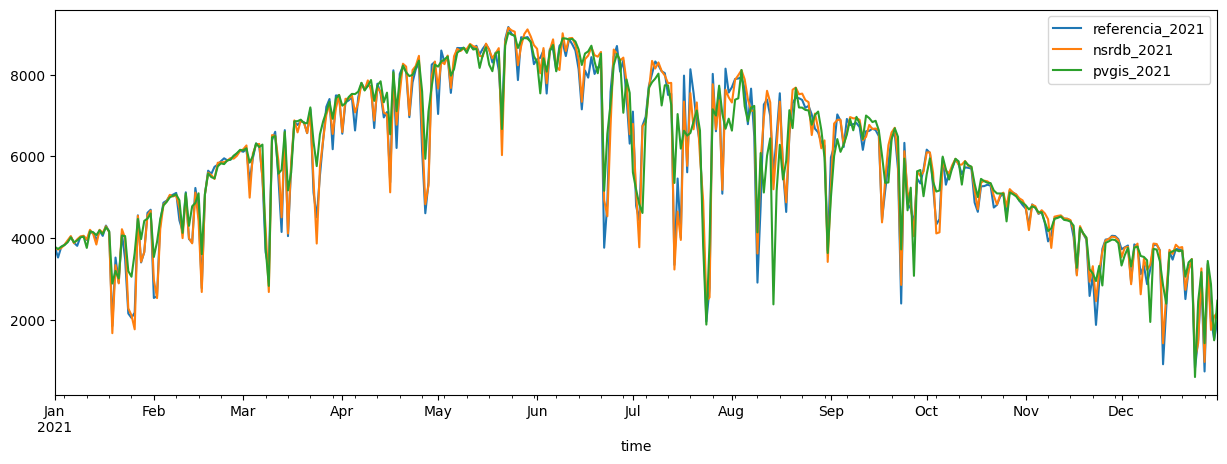

In [155]:
df_weather_ghi_horario_2021.resample("D").sum().plot(label ='referencia_2021', figsize=(15,5))
data_nsrdb_2021['ghi'].resample('D').sum().plot(label ='nsrdb_2021', figsize=(15,5))
df_2021['poa_global_2021'].resample('D').sum().plot(label ='pvgis_2021', figsize=(15,5))
plt.legend()

### **1.5.4 Comparação das Métricas de Avaliação**
Pra escolha do Database metereológico foram aplicadas as métricas de avaliação RMSE, MAE e R2 para o GHI.


**Ano 2019**

In [156]:
daily_reference_2019 = df_weather_ghi_horario_2019.resample("D").sum()
daily_nsrdb_2019 = data_nsrdb_2019['ghi'].resample('D').sum()
daily_pvgis_2019 = df['poa_global'].resample('D').sum()

In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pvlib.solarposition import get_solarposition
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Métricas de avaliação
rmse = np.sqrt(mean_squared_error(daily_reference_2019, daily_nsrdb_2019))
mae = mean_absolute_error(daily_reference_2019, daily_nsrdb_2019)
r2 = r2_score(daily_reference_2019, daily_nsrdb_2019)
bias = np.mean(daily_nsrdb_2019 - daily_reference_2019)

print("\n--- Métricas de Avaliação NSRDB 2019---")
print(f"RMSE: {rmse:.2f} W/m²")
print(f"MAE: {mae:.2f} W/m²")
print(f"R²: {r2:.4f}")
print(f"Bias (Calculado - Medido): {bias:.2f} W/m²")

rmse = np.sqrt(mean_squared_error(daily_reference_2019, daily_pvgis_2019))
mae = mean_absolute_error(daily_reference_2019, daily_pvgis_2019)
r2 = r2_score(daily_reference_2019, daily_pvgis_2019)
bias = np.mean(daily_nsrdb_2019 - daily_pvgis_2019)

print("\n--- Métricas de Avaliação PVGIS 2019 ---")
print(f"RMSE: {rmse:.2f} W/m²")
print(f"MAE: {mae:.2f} W/m²")
print(f"R²: {r2:.4f}")
print(f"Bias (Calculado - Medido): {bias:.2f} W/m²")


--- Métricas de Avaliação NSRDB 2019---
RMSE: 316.10 W/m²
MAE: 221.24 W/m²
R²: 0.9762
Bias (Calculado - Medido): nan W/m²

--- Métricas de Avaliação PVGIS 2019 ---
RMSE: 550.27 W/m²
MAE: 356.16 W/m²
R²: 0.9278
Bias (Calculado - Medido): 46.38 W/m²


* Constata-se que os dados do NSRDB, para o ano de 2019, possui melhor aderência aos dados medidos pela estação UAT, em comparação com os dados do PVGIS.

**Ano 2020**


In [158]:
daily_reference_2020 = df_weather_ghi_horario_2020.resample("D").sum()
daily_nsrdb_2020 = data_nsrdb_2020['ghi'].resample('D').sum()
daily_pvgis_2020 = df_2020['poa_global_2020'].resample('D').sum()

In [159]:
#dados do ano de 2020
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pvlib.solarposition import get_solarposition
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Métricas de avaliação
rmse = np.sqrt(mean_squared_error(daily_reference_2020, daily_nsrdb_2020))
mae = mean_absolute_error(daily_reference_2020, daily_nsrdb_2020)
r2 = r2_score(daily_reference_2020, daily_nsrdb_2020)
bias = np.mean(daily_nsrdb_2020 - daily_reference_2020)

print("\n--- Métricas de Avaliação NSRDB 2020---")
print(f"RMSE: {rmse:.2f} W/m²")
print(f"MAE: {mae:.2f} W/m²")
print(f"R²: {r2:.4f}")
print(f"Bias (Calculado - Medido): {bias:.2f} W/m²")

rmse = np.sqrt(mean_squared_error(daily_reference_2020, daily_pvgis_2020))
mae = mean_absolute_error(daily_reference_2020, daily_pvgis_2020)
r2 = r2_score(daily_reference_2020, daily_pvgis_2020)
bias = np.mean(daily_nsrdb_2020 - daily_pvgis_2020)

print("\n--- Métricas de Avaliação PVGIS 2020 ---")
print(f"RMSE: {rmse:.2f} W/m²")
print(f"MAE: {mae:.2f} W/m²")
print(f"R²: {r2:.4f}")
print(f"Bias (Calculado - Medido): {bias:.2f} W/m²")


--- Métricas de Avaliação NSRDB 2020---
RMSE: 331.02 W/m²
MAE: 205.80 W/m²
R²: 0.9712
Bias (Calculado - Medido): nan W/m²

--- Métricas de Avaliação PVGIS 2020 ---
RMSE: 596.01 W/m²
MAE: 338.63 W/m²
R²: 0.9066
Bias (Calculado - Medido): -73.54 W/m²


Constata-se que os dados do NSRDB, para o ano de 2020, continua sendo a base indicada.

**2021**


In [160]:
daily_reference_2021 = df_weather_ghi_horario_2021.resample("D").sum()
daily_nsrdb_2021 = data_nsrdb_2021['ghi'].resample('D').sum()
daily_pvgis_2021 = df_2021['poa_global_2021'].resample('D').sum()

In [161]:
#dados do ano de 2021
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pvlib.solarposition import get_solarposition
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Métricas de avaliação
rmse = np.sqrt(mean_squared_error(daily_reference_2021, daily_nsrdb_2021))
mae = mean_absolute_error(daily_reference_2021, daily_nsrdb_2021)
r2 = r2_score(daily_reference_2021, daily_nsrdb_2021)
bias = np.mean(daily_nsrdb_2021 - daily_reference_2021)

print("\n--- Métricas de Avaliação NSRDB 2021---")
print(f"RMSE: {rmse:.2f} W/m²")
print(f"MAE: {mae:.2f} W/m²")
print(f"R²: {r2:.4f}")
print(f"Bias (Calculado - Medido): {bias:.2f} W/m²")

rmse = np.sqrt(mean_squared_error(daily_reference_2021, daily_pvgis_2021))
mae = mean_absolute_error(daily_reference_2021, daily_pvgis_2021)
r2 = r2_score(daily_reference_2021, daily_pvgis_2021)
bias = np.mean(daily_nsrdb_2021 - daily_pvgis_2021)

print("\n--- Métricas de Avaliação PVGIS 2021 ---")
print(f"RMSE: {rmse:.2f} W/m²")
print(f"MAE: {mae:.2f} W/m²")
print(f"R²: {r2:.4f}")
print(f"Bias (Calculado - Medido): {bias:.2f} W/m²")


--- Métricas de Avaliação NSRDB 2021---
RMSE: 264.02 W/m²
MAE: 180.69 W/m²
R²: 0.9812
Bias (Calculado - Medido): nan W/m²

--- Métricas de Avaliação PVGIS 2021 ---
RMSE: 613.11 W/m²
MAE: 379.52 W/m²
R²: 0.8984
Bias (Calculado - Medido): -62.40 W/m²


* Novamente, constata-se que os dados do NSRDB, para o ano de 2021, continua sendo a base indicada em comparação com a base de dados do PVGIS.


---



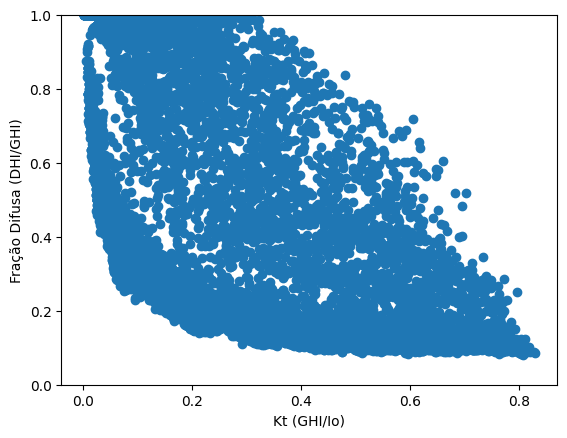

In [162]:
# Kt x Diffuse Fraction


dni_extra = pvlib.irradiance.get_extra_radiation(nsrdb_data_3Y.index)



Kt = nsrdb_data_3Y['ghi']/dni_extra

diff_fraction = nsrdb_data_3Y['dhi']/nsrdb_data_3Y['ghi']

plt.scatter(Kt, diff_fraction)
plt.ylim(0, 1)
plt.xlabel('Kt (GHI/Io)')
plt.ylabel('Fração Difusa (DHI/GHI)')
plt.show()


### **1.5.5 Conclusão da Escolha da Base de Dados de Satélite (GHI)**

Em função das análises das métricas de avaliação realizadas nos itens anteriores, a base de dados do NSRDB será adotada para a geração dos dados de GHI, os quais serão utilizados para obter os valores de do DNI e DHI, por meio de diversos métodos de decomposicao.

## **1.6 Métodos de Decomposição para Determinacao do DNI e DHI**


A partir dos valores gerados de GHI da base de dados do NSRDB, os valores de DNI e DHI foram determinados pelos métodos de decomposicao, a saber:

**1.   ERBS**
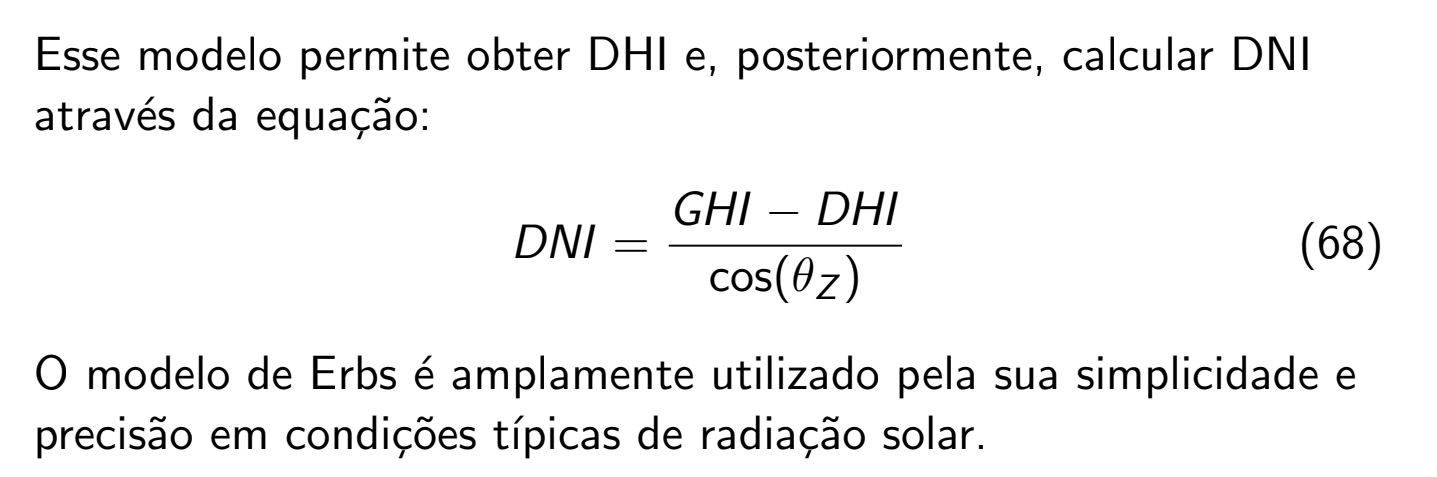
**2.   DIRINT**
* O modelo DIRINT  ́e uma modificacao dinamica do modelo DISC.
* Objetivo: Estimar a Irradiancia Normal Direta (DNI) a partir da Irradiancia Global Horizontal (GHI).
* Desenvolvido por Perez et al. (1992).
* Usa séries temporais de GHI e pode incluir a temperatura do ponto de orvalho (Tdew).


**3.   DISC**

O modelo DISC (*Direct Insolation Simulation Code*) em pvlib é uma metodologia que estima a Irradiância Normal Direta (DNI) a partir da Irradiância Horizontal Global (GHI). Ele foi desenvolvido no National Renewable Energy Laboratory (NREL) em 1987 e utiliza relações empíricas entre os índices de nebulosidade global e direta para decompor a irradiância solar.

[1] Maxwell, E. L., "A Quasi-Physical Model for Converting Hourly
        Global Horizontal to Direct Normal Insolation", Technical
        Report No. SERI/TR-215-3087, Golden, CO: Solar Energy Research
        Institute, 1987.

[2] Maxwell, E. "DISC Model", Excel Worksheet.
        https://www.nrel.gov/grid/solar-resource/disc.html

**4.   BOLAND**

>   Como referência, foram utilizados os programas desenvolvidos no Notebook 3 e auxílio complementar de IA



### **1.6.1 Decomposição referente ao ano de 2019**










In [163]:
from pvlib import irradiance
import pvlib # Import pvlib

# Use os dados de 2019 do NSRDB para o cálculo da posição solar
solpos = pvlib.solarposition.get_solarposition(time=data_nsrdb_2019.index,
                                                latitude=latitude,
                                                longitude=longitude)

# O modelo Erbs utiliza o GHI medido e o ângulo zenital solar.
# Usando GHI dos dados de 2019 do NSRDB
out_erbs = irradiance.erbs(data_nsrdb_2019['ghi'], solpos['zenith'], data_nsrdb_2019.index)
out_erbs = out_erbs.rename(columns={'dni': 'dni_erbs', 'dhi': 'dhi_erbs'})

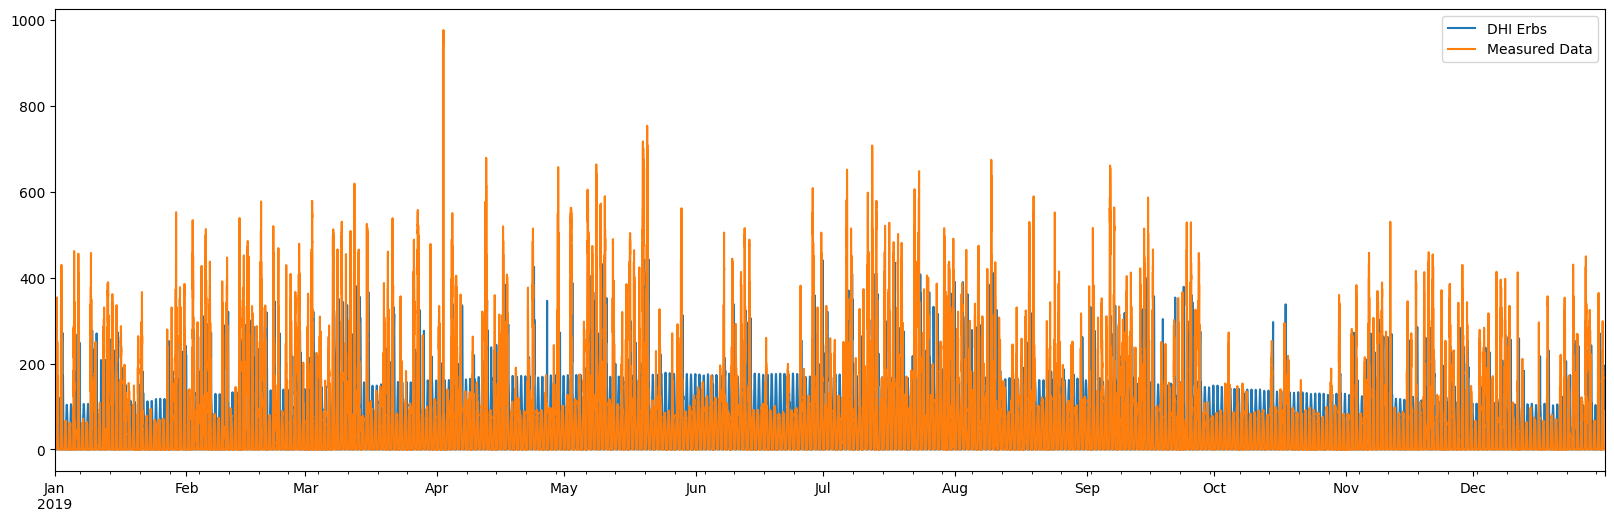

In [164]:
out_erbs['dhi_erbs'].plot(label = 'DHI Erbs', figsize=(20,6))
df_weather['dhi'].plot(label = 'Measured Data')
plt.legend()
plt.show()

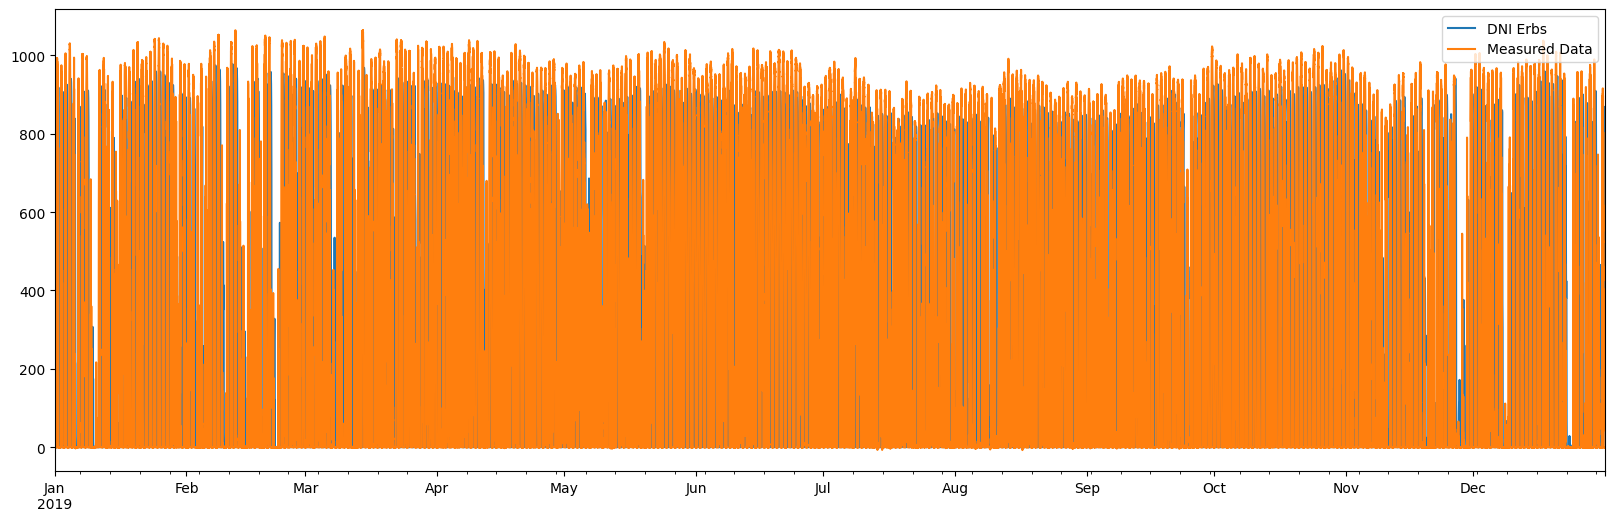

In [165]:
out_erbs['dni_erbs'].plot(label = 'DNI Erbs', figsize=(20,6))
df_weather['dni'].plot(label = 'Measured Data')
plt.legend()
plt.show()

In [166]:
#Modelagem de Decomposição com outros modelos de decomposição
#DISC - O modelo DISC utiliza o GHI medido, o ângulo zenital solar, o índice temporal e a pressão do ar.
# Usando dados de 2019 do NSRDB
out_disc = irradiance.disc(
    data_nsrdb_2019['ghi'], solpos.zenith, data_nsrdb_2019.index, data_nsrdb_2019['pressure']*100)
# use "complete sum" AKA "closure" equations: DHI = GHI - DNI * cos(zenith)
df_disc = irradiance.complete_irradiance(
    solar_zenith=solpos.apparent_zenith, ghi=data_nsrdb_2019['ghi'], dni=out_disc.dni,
    dhi=None)
out_disc = out_disc.rename(columns={'dni': 'dni_disc'})
out_disc['dhi_disc'] = df_disc.dhi

#BOLAND - O modelo Boland utiliza o GHI medido, o ângulo zenital solar e o índice temporal.
# Usando dados de 2019 do NSRDB
out_boland = irradiance.boland(data_nsrdb_2019['ghi'], solpos.zenith, data_nsrdb_2019.index)
out_boland = out_boland.rename(
    columns={'dni': 'dni_boland', 'dhi': 'dhi_boland'})

#DIRINT - O modelo Dirint utiliza o GHI medido, o ângulo zenital solar, o índice temporal e a pressão do ar.
# Usando dados de 2019 do NSRDB
dni_dirint = irradiance.dirint(
    data_nsrdb_2019['ghi'], solpos.zenith, data_nsrdb_2019.index, data_nsrdb_2019['pressure']*100,
    temp_dew=None)
# use "complete sum" AKA "closure" equation: DHI = GHI - DNI * cos(zenith)
df_dirint = irradiance.complete_irradiance(
    solar_zenith=solpos.apparent_zenith, ghi=data_nsrdb_2019['ghi'], dni=dni_dirint,
    dhi=None)
out_dirint = pd.DataFrame(
    {'dni_dirint': dni_dirint, 'dhi_dirint': df_dirint.dhi},
    index=data_nsrdb_2019.index)

546443.8497978242
523142.27947037003
534744.9623122863
626237.4225420272
33249306.14111601


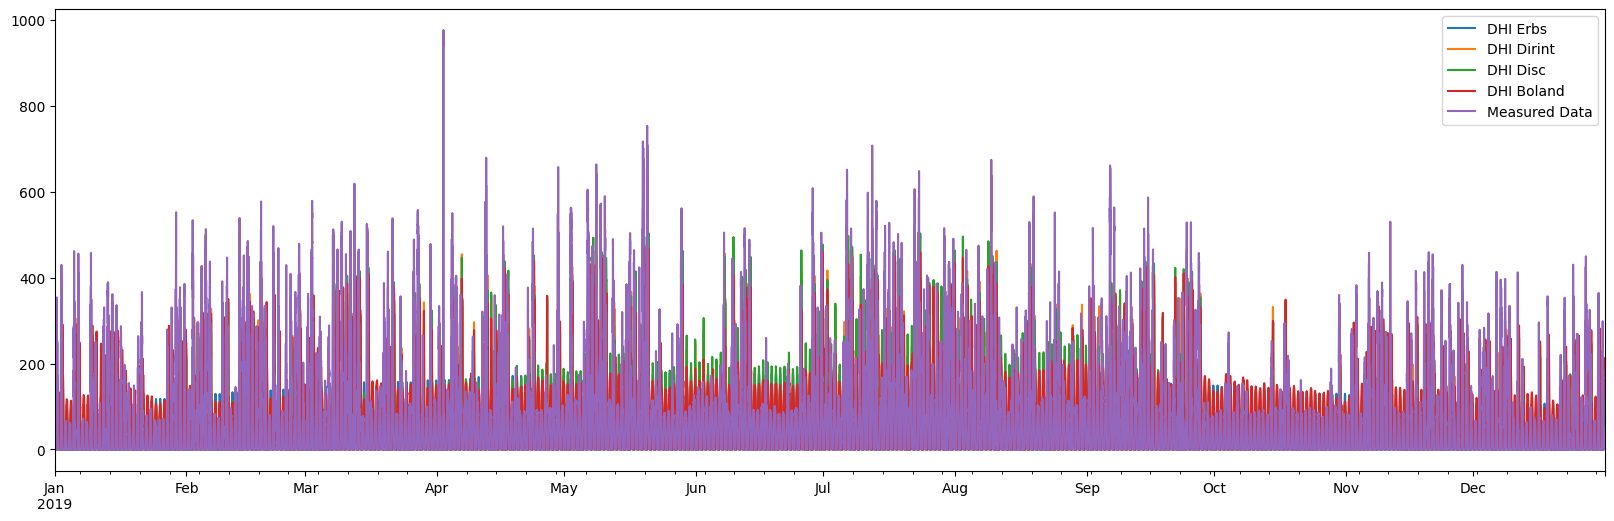

In [167]:
#Comparando DHI
out_erbs['dhi_erbs'].plot(label = 'DHI Erbs', figsize=(20,6))
out_dirint['dhi_dirint'].plot(label = 'DHI Dirint')
out_disc['dhi_disc'].plot(label = 'DHI Disc')
out_boland['dhi_boland'].plot(label = 'DHI Boland')
df_weather['dhi'].plot(label = 'Measured Data')
print(out_erbs['dhi_erbs'].sum())
print(out_dirint['dhi_dirint'].sum())
print(out_disc['dhi_disc'].sum())
print(out_boland['dhi_boland'].sum())
print(df_weather['dhi'].sum())
plt.legend()
plt.show()

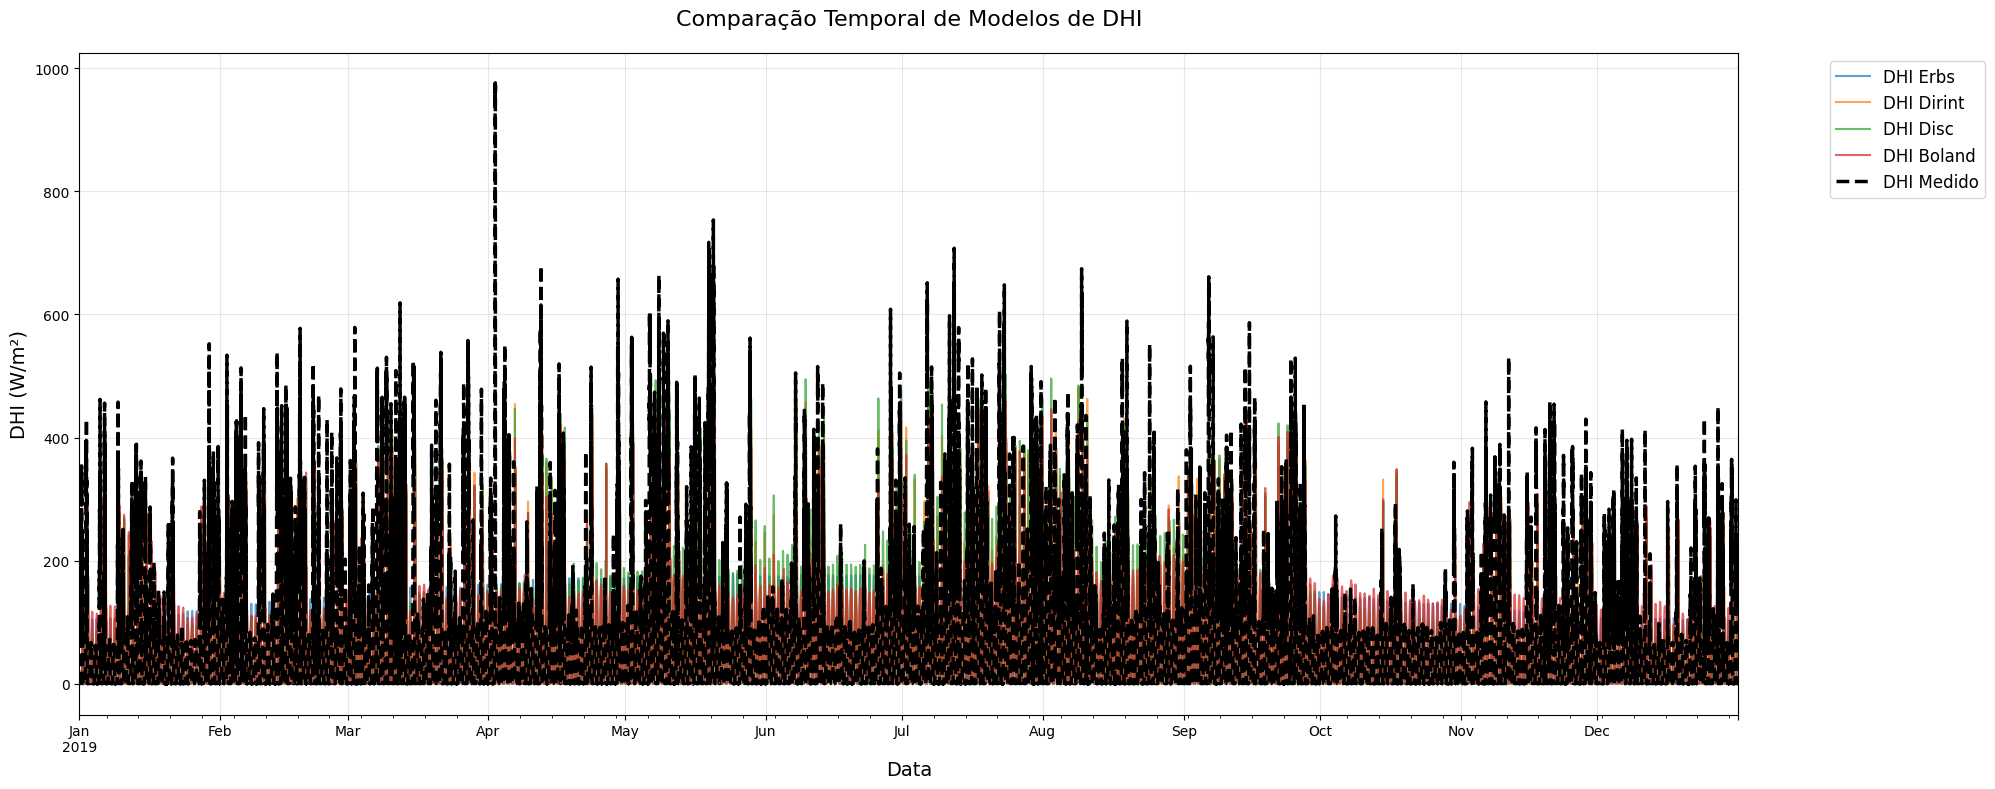

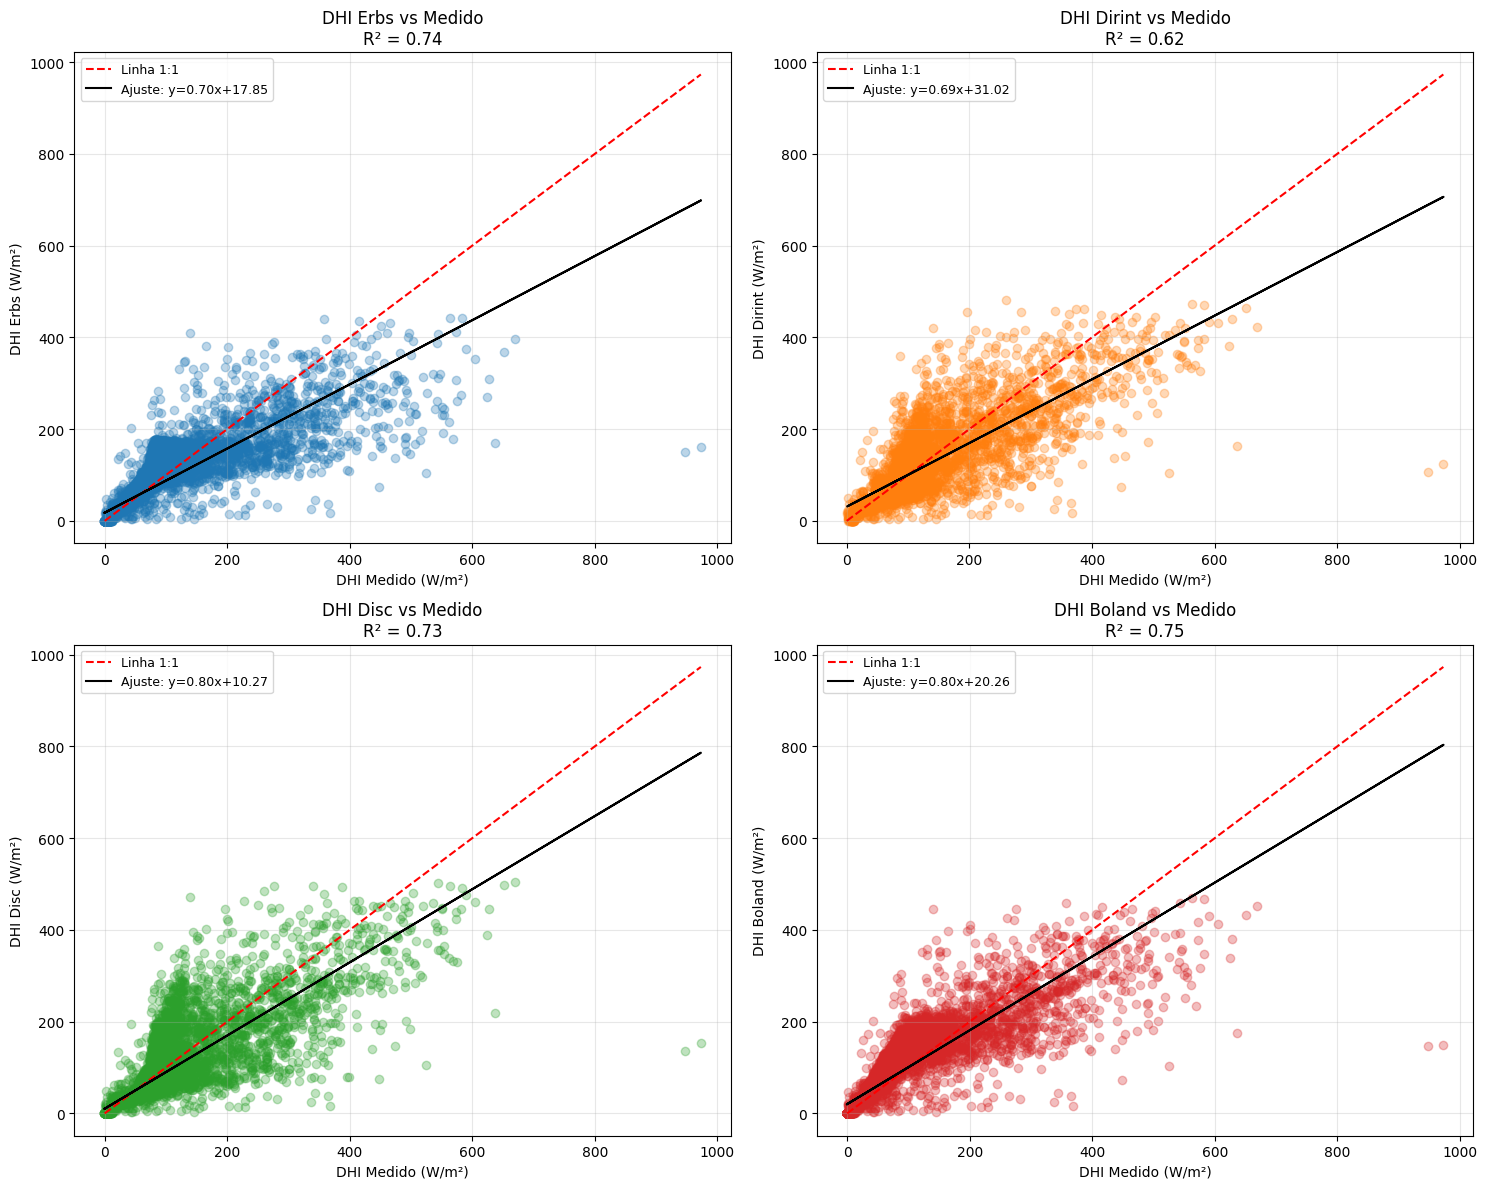

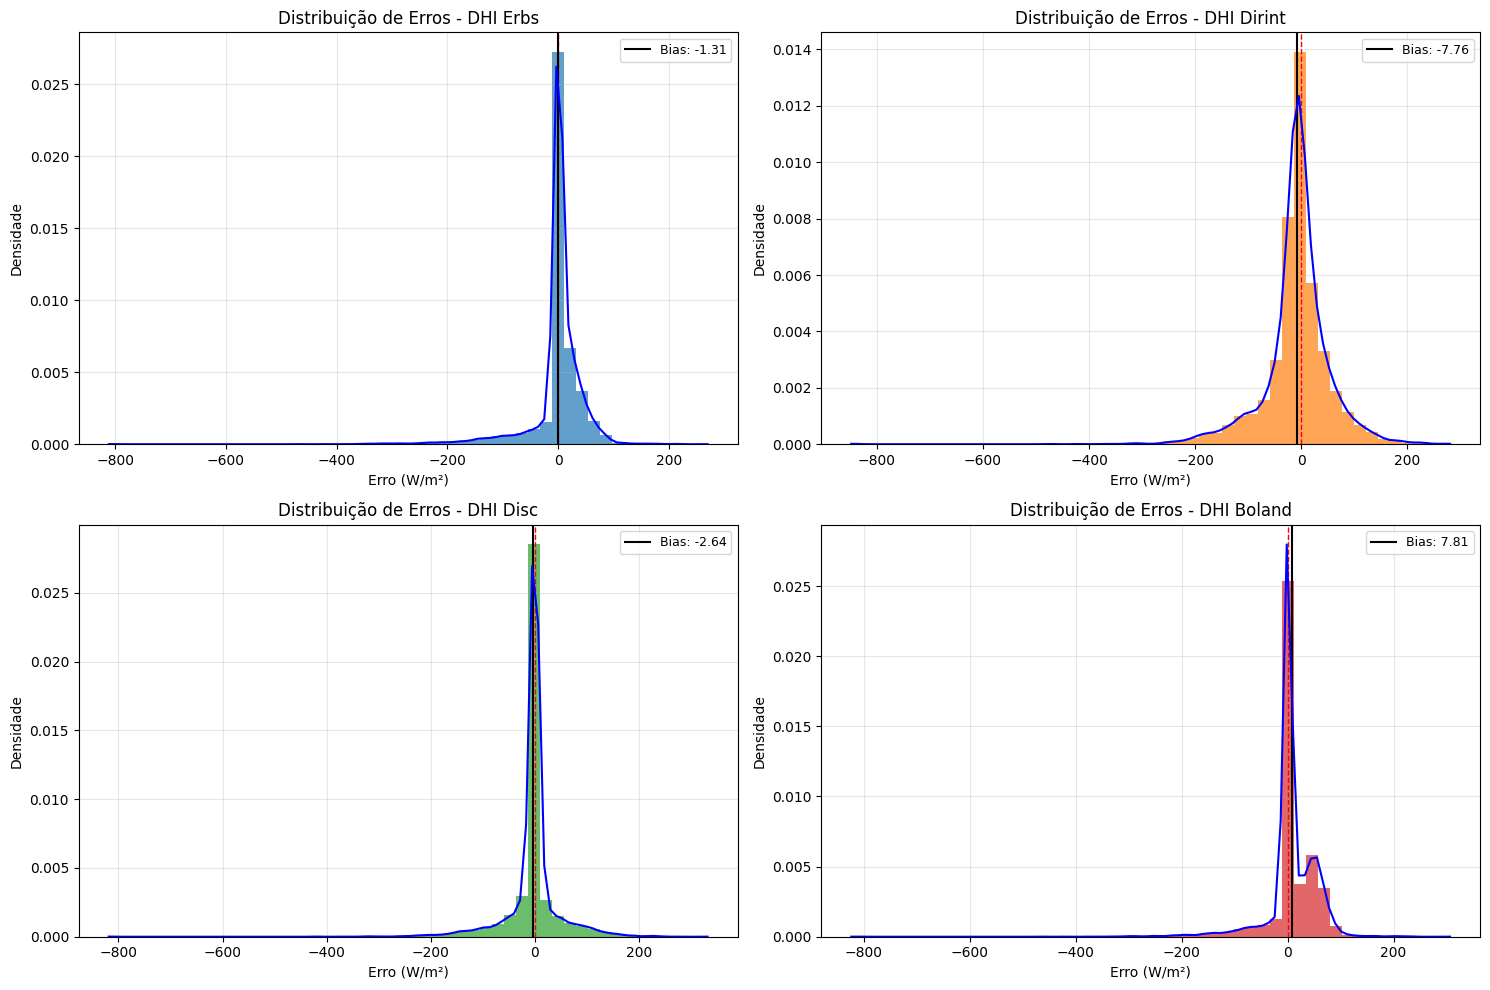

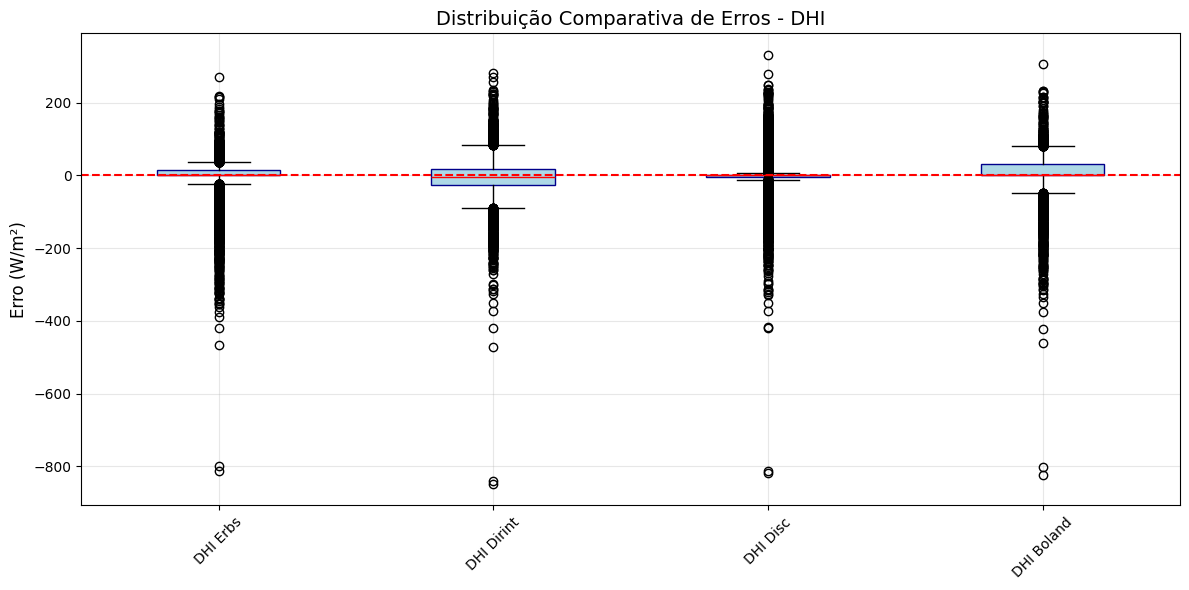

In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import gaussian_kde

# Dados dos modelos para DHI
models_dhi = {
    'DHI Erbs': out_erbs['dhi_erbs'],
    'DHI Dirint': out_dirint['dhi_dirint'],
    'DHI Disc': out_disc['dhi_disc'],
    'DHI Boland': out_boland['dhi_boland']
}

# Dados medidos para DHI
measured_dhi = df_weather['dhi']

# 1. Plot comparativo temporal DHI
plt.figure(figsize=(20, 8))
for name, model in models_dhi.items():
    model.plot(label=name, alpha=0.7, linewidth=1.5)
measured_dhi.plot(label='DHI Medido', color='black', linewidth=2.5, style='--')
plt.title('Comparação Temporal de Modelos de DHI', fontsize=16, pad=20)
plt.xlabel('Data', fontsize=14)
plt.ylabel('DHI (W/m²)', fontsize=14)
plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Cálculo das métricas para DHI
metrics_dhi = pd.DataFrame(columns=['RMSE (W/m²)', 'MAE (W/m²)', 'R²', 'Bias (W/m²)'])

for name, model in models_dhi.items():
    valid_idx = measured_dhi.notna() & model.notna()
    y_true = measured_dhi[valid_idx]
    y_pred = model[valid_idx]

    # Check if there are enough samples for metrics calculation
    if len(y_true) > 1:
        metrics_dhi.loc[name] = {
            'RMSE (W/m²)': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE (W/m²)': mean_absolute_error(y_true, y_pred),
            'R²': r2_score(y_true, y_pred),
            'Bias (W/m²)': np.mean(y_pred - y_true)
        }
    else:
        metrics_dhi.loc[name] = {col: np.nan for col in metrics_dhi.columns}


# 3. Gráficos de dispersão com ajuste linear para DHI
plt.figure(figsize=(15, 12))
for i, (name, model) in enumerate(models_dhi.items(), 1):
    plt.subplot(2, 2, i)

    valid_idx = measured_dhi.notna() & model.notna()
    x = measured_dhi[valid_idx]
    y = model[valid_idx]

    if len(x) > 1:
        plt.scatter(x, y, alpha=0.3, color=plt.cm.tab10(i-1))
        plt.plot([0, max(x)], [0, max(x)], 'r--', label='Linha 1:1')

        coef = np.polyfit(x, y, 1)
        poly1d_fn = np.poly1d(coef)
        plt.plot(x, poly1d_fn(x), 'k-', label=f'Ajuste: y={coef[0]:.2f}x+{coef[1]:.2f}')

        plt.xlabel('DHI Medido (W/m²)', fontsize=10)
        plt.ylabel(f'{name} (W/m²)', fontsize=10)
        plt.title(f'{name} vs Medido\nR² = {metrics_dhi.loc[name, "R²"]:.2f}', fontsize=12)
        plt.legend(fontsize=9)
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Dados insuficientes', ha='center', va='center')
        plt.title(f'{name} (Dados insuficientes)')

plt.tight_layout()
plt.show()

# 4. Análise de distribuição de erros para DHI
plt.figure(figsize=(15, 10))
for i, (name, model) in enumerate(models_dhi.items(), 1):
    error = model - measured_dhi

    clean_error = error.replace([np.inf, -np.inf], np.nan).dropna()

    if len(clean_error) == 0:
        plt.subplot(2, 2, i)
        plt.text(0.5, 0.5, 'Dados insuficientes', ha='center', va='center')
        plt.title(f'Distribuição de Erros - {name}')
        continue

    plt.subplot(2, 2, i)
    n, bins, patches = plt.hist(clean_error, bins=50, density=True,
                              alpha=0.7, color=plt.cm.tab10(i-1))
    plt.axvline(x=0, color='r', linestyle='--', linewidth=1)
    current_bias = np.mean(clean_error)
    plt.axvline(x=current_bias, color='k',
               linestyle='-', linewidth=1.5, label=f'Bias: {current_bias:.2f}')

    try:
        kde = gaussian_kde(clean_error)
        x_vals = np.linspace(min(clean_error), max(clean_error), 100)
        plt.plot(x_vals, kde(x_vals), 'b-', linewidth=1.5)
    except Exception as e:
        print(f"\nAviso: Não foi possível calcular KDE para {name}. Erro: {str(e)}")

    plt.title(f'Distribuição de Erros - {name}', fontsize=12)
    plt.xlabel('Erro (W/m²)', fontsize=10)
    plt.ylabel('Densidade', fontsize=10)
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Boxplot comparativo de erros para DHI
plt.figure(figsize=(12, 6))
all_errors_dhi = []
labels_dhi = []
for name, model in models_dhi.items():
    error = model - measured_dhi
    clean_error = error.replace([np.inf, -np.inf], np.nan).dropna()

    if len(clean_error) > 0:
        all_errors_dhi.append(clean_error)
        labels_dhi.append(name)

if len(all_errors_dhi) > 0:
    plt.boxplot(all_errors_dhi, tick_labels=labels_dhi, patch_artist=True,
               boxprops=dict(facecolor='lightblue', color='darkblue'),
               medianprops=dict(color='red'))
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Distribuição Comparativa de Erros - DHI', fontsize=14)
    plt.ylabel('Erro (W/m²)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\nAviso: Não há dados válidos para gerar o boxplot comparativo de DHI.")

# Calculate total energy for DHI
energy_dhi = pd.DataFrame(columns=['Energia Total (Wh/m²)'])
for name, model in models_dhi.items():
    energy_dhi.loc[name] = model.sum()
energy_dhi.loc['Dados Medidos'] = measured_dhi.sum()

2520496.669915722
2633744.728839728
2659026.419783421
2357155.09389582
152343142.62619603


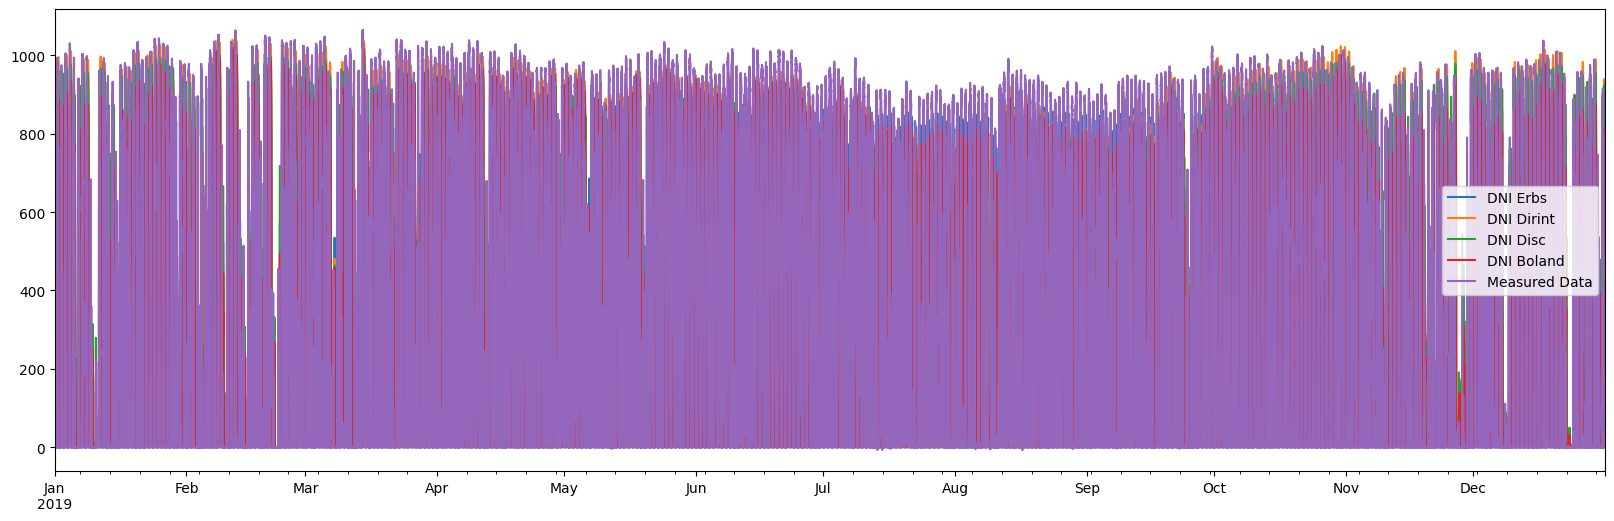

In [169]:
#Comparando DNI
out_erbs['dni_erbs'].plot(label = 'DNI Erbs', figsize=(20,6))
out_dirint['dni_dirint'].plot(label = 'DNI Dirint')
out_disc['dni_disc'].plot(label = 'DNI Disc')
out_boland['dni_boland'].plot(label = 'DNI Boland')
df_weather['dni'].plot(label = 'Measured Data')
print(out_erbs['dni_erbs'].sum())
print(out_dirint['dni_dirint'].sum())
print(out_disc['dni_disc'].sum())
print(out_boland['dni_boland'].sum())
print(df_weather['dni'].sum())
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import gaussian_kde

# Dados dos modelos para DNI
models_dni = {
    'DNI Erbs': out_erbs['dni_erbs'],
    'DNI Dirint': out_dirint['dni_dirint'],
    'DNI Disc': out_disc['dni_disc'],
    'DNI Boland': out_boland['dni_boland']
}

# Dados medidos para DNI
measured_dni = df_weather['dni']

# 1. Plot comparativo temporal DNI
plt.figure(figsize=(20, 8))
for name, model in models_dni.items():
    model.plot(label=name, alpha=0.7, linewidth=1.5)
measured_dni.plot(label='DNI Medido', color='black', linewidth=2.5, style='--')
plt.title('Comparação Temporal de Modelos de DNI', fontsize=16, pad=20)
plt.xlabel('Data', fontsize=14)
plt.ylabel('DNI (W/m²)', fontsize=14)
plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Cálculo das métricas para DNI
metrics_dni = pd.DataFrame(columns=['RMSE (W/m²)', 'MAE (W/m²)', 'R²', 'Bias (W/m²)'])

for name, model in models_dni.items():
    valid_idx = measured_dni.notna() & model.notna() & ~np.isinf(model)
    y_true = measured_dni[valid_idx]
    y_pred = model[valid_idx]

    if len(y_true) > 1:
        metrics_dni.loc[name] = {
            'RMSE (W/m²)': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE (W/m²)': mean_absolute_error(y_true, y_pred),
            'R²': r2_score(y_true, y_pred),
            'Bias (W/m²)': np.mean(y_pred - y_true)
        }
    else:
         metrics_dni.loc[name] = {col: np.nan for col in metrics_dni.columns}


# 3. Gráficos de dispersão com ajuste linear para DNI
plt.figure(figsize=(15, 12))
for i, (name, model) in enumerate(models_dni.items(), 1):
    plt.subplot(2, 2, i)

    valid_idx = measured_dni.notna() & model.notna() & ~np.isinf(model) & ~np.isinf(measured_dni)
    x = measured_dni[valid_idx]
    y = model[valid_idx]

    if len(x) > 1:
        plt.scatter(x, y, alpha=0.3, color=plt.cm.tab10(i-1))
        plt.plot([0, max(x)], [0, max(x)], 'r--', label='Linha 1:1')

        try:
            coef = np.polyfit(x, y, 1)
            poly1d_fn = np.poly1d(coef)
            plt.plot(x, poly1d_fn(x), 'k-', label=f'Ajuste: y={coef[0]:.2f}x+{coef[1]:.2f}')
            r2 = r2_score(x, y)
        except:
            r2 = np.nan

        plt.xlabel('DNI Medido (W/m²)', fontsize=10)
        plt.ylabel(f'{name} (W/m²)', fontsize=10)
        plt.title(f'{name} vs Medido\nR² = {r2:.2f}' if not np.isnan(r2) else f'{name} vs Medido', fontsize=12)
        plt.legend(fontsize=9)
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Dados insuficientes', ha='center', va='center')
        plt.title(f'{name} (Dados insuficientes)')


plt.tight_layout()
plt.show()

# 4. Análise de distribuição de erros para DNI
plt.figure(figsize=(15, 10))
for i, (name, model) in enumerate(models_dni.items(), 1):
    error = model - measured_dni

    clean_error = error.replace([np.inf, -np.inf], np.nan).dropna()

    if len(clean_error) == 0:
        plt.subplot(2, 2, i)
        plt.text(0.5, 0.5, 'Dados insuficientes', ha='center', va='center')
        plt.title(f'Distribuição de Erros - {name}')
        continue

    plt.subplot(2, 2, i)
    n, bins, patches = plt.hist(clean_error, bins=50, density=True,
                              alpha=0.7, color=plt.cm.tab10(i-1))
    plt.axvline(x=0, color='r', linestyle='--', linewidth=1)
    current_bias = np.mean(clean_error)
    plt.axvline(x=current_bias, color='k',
               linestyle='-', linewidth=1.5, label=f'Bias: {current_bias:.2f}')

    try:
        kde = gaussian_kde(clean_error)
        x_vals = np.linspace(min(clean_error), max(clean_error), 100)
        plt.plot(x_vals, kde(x_vals), 'b-', linewidth=1.5)
    except Exception as e:
        print(f"\nAviso: Não foi possível calcular KDE para {name}. Erro: {str(e)}")

    plt.title(f'Distribuição de Erros - {name}', fontsize=12)
    plt.xlabel('Erro (W/m²)', fontsize=10)
    plt.ylabel('Densidade', fontsize=10)
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Boxplot comparativo de erros para DNI
plt.figure(figsize=(12, 6))
all_errors_dni = []
labels_dni = []
for name, model in models_dni.items():
    error = model - measured_dni
    clean_error = error.replace([np.inf, -np.inf], np.nan).dropna()

    if len(clean_error) > 0:
        all_errors_dni.append(clean_error)
        labels_dni.append(name)

if len(all_errors_dni) > 0:
    plt.boxplot(all_errors_dni, tick_labels=labels_dni, patch_artist=True,
               boxprops=dict(facecolor='lightblue', color='darkblue'),
               medianprops=dict(color='red'))
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Distribuição Comparativa de Erros - DNI', fontsize=14)
    plt.ylabel('Erro (W/m²)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\nAviso: Não há dados válidos para gerar o boxplot comparativo de DNI.")

# Calculate total energy for DNI
energy_dni = pd.DataFrame(columns=['Energia Total (Wh/m²)'])
for name, model in models_dni.items():
    energy_dni.loc[name] = model.sum()
energy_dni.loc['Dados Medidos'] = measured_dni.sum()

# Combine metrics into a single table
metrics_combined = pd.concat([metrics_dhi, metrics_dni], keys=['DHI', 'DNI'], names=['Irradiance Component', 'Model'])
energy_combined = pd.concat([energy_dhi, energy_dni], keys=['DHI', 'DNI'], names=['Irradiance Component', 'Model'])

# Add measured data row to the combined metrics table
metrics_combined.loc[('DHI', 'Dados Medidos'), :] = np.nan
metrics_combined.loc[('DNI', 'Dados Medidos'), :] = np.nan

# Combine metrics and energy
combined_results = pd.concat([metrics_combined, energy_combined], axis=1)

# Display the combined table
pd.set_option('display.float_format', '{:.2f}'.format)
print("\n=== Métricas de Desempenho Combinadas (DHI e DNI) ===")
print(combined_results)

**Conclusões para ano de 2019:**

Após as simulações, foi possível verificar que, em relação ao RMSE:

*  DHI Boland apresentou melhor resultado, pois os seus dados estao mais aderente aos dados medidos na estacao da UAT;
*  DNI Erbs apresentou o melhor resultado, seguido por Boland com pequena diferenca.

### **1.6.2 Decomposição referente ao ano de 2020**



>

In [ ]:
from pvlib import irradiance
import pvlib # Import pvlib

# Use os dados de 2020 do NSRDB para o cálculo da posição solar
solpos = pvlib.solarposition.get_solarposition(time=data_nsrdb_2020.index,
                                                latitude=latitude,
                                                longitude=longitude)

# O modelo Erbs utiliza o GHI medido e o ângulo zenital solar.
# Usando GHI dos dados de 2020 do NSRDB
out_erbs = irradiance.erbs(data_nsrdb_2020['ghi'], solpos['zenith'], data_nsrdb_2020.index)
out_erbs = out_erbs.rename(columns={'dni': 'dni_erbs', 'dhi': 'dhi_erbs'})

out_erbs['dhi_erbs'].plot(label = 'DHI Erbs', figsize=(20,6))
df_weather_2020['dhi'].plot(label = 'Measured Data')
plt.legend()
plt.show()

out_erbs['dni_erbs'].plot(label = 'DNI Erbs', figsize=(20,6))
df_weather_2020['dni'].plot(label = 'Measured Data')
plt.legend()
plt.show()

#Modelagem de Decomposição com outros modelos de decomposição
#DISC - O modelo DISC utiliza o GHI medido, o ângulo zenital solar, o índice temporal e a pressão do ar.
# Usando dados de 2020 do NSRDB
out_disc = irradiance.disc(
    data_nsrdb_2020['ghi'], solpos.zenith, data_nsrdb_2020.index, data_nsrdb_2020['pressure']*100)
# use "complete sum" AKA "closure" equations: DHI = GHI - DNI * cos(zenith)
df_disc = irradiance.complete_irradiance(
    solar_zenith=solpos.apparent_zenith, ghi=data_nsrdb_2020['ghi'], dni=out_disc.dni,
    dhi=None)
out_disc = out_disc.rename(columns={'dni': 'dni_disc'})
out_disc['dhi_disc'] = df_disc.dhi

#BOLAND - O modelo Boland utiliza o GHI medido, o ângulo zenital solar e o índice temporal.
# Usando dados de 2020 do NSRDB
out_boland = irradiance.boland(data_nsrdb_2020['ghi'], solpos.zenith, data_nsrdb_2020.index)
out_boland = out_boland.rename(
    columns={'dni': 'dni_boland', 'dhi': 'dhi_boland'})

#DIRINT - O modelo Dirint utiliza o GHI medido, o ângulo zenital solar, o índice temporal e a pressão do ar.
# Usando dados de 2020 do NSRDB
dni_dirint = irradiance.dirint(
    data_nsrdb_2020['ghi'], solpos.zenith, data_nsrdb_2020.index, data_nsrdb_2020['pressure']*100,
    temp_dew=None)
# use "complete sum" AKA "closure" equation: DHI = GHI - DNI * cos(zenith)
df_dirint = irradiance.complete_irradiance(
    solar_zenith=solpos.apparent_zenith, ghi=data_nsrdb_2020['ghi'], dni=dni_dirint,
    dhi=None)
out_dirint = pd.DataFrame(
    {'dni_dirint': dni_dirint, 'dhi_dirint': df_dirint.dhi},
    index=data_nsrdb_2020.index)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import gaussian_kde

# Dados dos modelos para DNI
models_dni = {
    'DNI Erbs': out_erbs['dni_erbs'],
    'DNI Dirint': out_dirint['dni_dirint'],
    'DNI Disc': out_disc['dni_disc'],
    'DNI Boland': out_boland['dni_boland']
}

# Dados medidos para DNI
measured_dni = df_weather_2020['dni']

# 1. Plot comparativo temporal DNI
plt.figure(figsize=(20, 8))
for name, model in models_dni.items():
    model.plot(label=name, alpha=0.7, linewidth=1.5)
measured_dni.plot(label='DNI Medido', color='black', linewidth=2.5, style='--')
plt.title('Comparação Temporal de Modelos de DNI', fontsize=16, pad=20)
plt.xlabel('Data', fontsize=14)
plt.ylabel('DNI (W/m²)', fontsize=14)
plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Cálculo das métricas para DNI
metrics_dni = pd.DataFrame(columns=['RMSE (W/m²)', 'MAE (W/m²)', 'R²', 'Bias (W/m²)'])

for name, model in models_dni.items():
    valid_idx = measured_dni.notna() & model.notna() & ~np.isinf(model)
    y_true = measured_dni[valid_idx]
    y_pred = model[valid_idx]

    if len(y_true) > 1:
        metrics_dni.loc[name] = {
            'RMSE (W/m²)': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE (W/m²)': mean_absolute_error(y_true, y_pred),
            'R²': r2_score(y_true, y_pred),
            'Bias (W/m²)': np.mean(y_pred - y_true)
        }
    else:
         metrics_dni.loc[name] = {col: np.nan for col in metrics_dni.columns}


# 3. Gráficos de dispersão com ajuste linear para DNI
plt.figure(figsize=(15, 12))
for i, (name, model) in enumerate(models_dni.items(), 1):
    plt.subplot(2, 2, i)

    valid_idx = measured_dni.notna() & model.notna() & ~np.isinf(model) & ~np.isinf(measured_dni)
    x = measured_dni[valid_idx]
    y = model[valid_idx]

    if len(x) > 1:
        plt.scatter(x, y, alpha=0.3, color=plt.cm.tab10(i-1))
        plt.plot([0, max(x)], [0, max(x)], 'r--', label='Linha 1:1')

        try:
            coef = np.polyfit(x, y, 1)
            poly1d_fn = np.poly1d(coef)
            plt.plot(x, poly1d_fn(x), 'k-', label=f'Ajuste: y={coef[0]:.2f}x+{coef[1]:.2f}')
            r2 = r2_score(x, y)
        except:
            r2 = np.nan

        plt.xlabel('DNI Medido (W/m²)', fontsize=10)
        plt.ylabel(f'{name} (W/m²)', fontsize=10)
        plt.title(f'{name} vs Medido\nR² = {r2:.2f}' if not np.isnan(r2) else f'{name} vs Medido', fontsize=12)
        plt.legend(fontsize=9)
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Dados insuficientes', ha='center', va='center')
        plt.title(f'{name} (Dados insuficientes)')


plt.tight_layout()
plt.show()

# 4. Análise de distribuição de erros para DNI
plt.figure(figsize=(15, 10))
for i, (name, model) in enumerate(models_dni.items(), 1):
    error = model - measured_dni

    clean_error = error.replace([np.inf, -np.inf], np.nan).dropna()

    if len(clean_error) == 0:
        plt.subplot(2, 2, i)
        plt.text(0.5, 0.5, 'Dados insuficientes', ha='center', va='center')
        plt.title(f'Distribuição de Erros - {name}')
        continue

    plt.subplot(2, 2, i)
    n, bins, patches = plt.hist(clean_error, bins=50, density=True,
                              alpha=0.7, color=plt.cm.tab10(i-1))
    plt.axvline(x=0, color='r', linestyle='--', linewidth=1)
    current_bias = np.mean(clean_error)
    plt.axvline(x=current_bias, color='k',
               linestyle='-', linewidth=1.5, label=f'Bias: {current_bias:.2f}')

    try:
        kde = gaussian_kde(clean_error)
        x_vals = np.linspace(min(clean_error), max(clean_error), 100)
        plt.plot(x_vals, kde(x_vals), 'b-', linewidth=1.5)
    except Exception as e:
        print(f"\nAviso: Não foi possível calcular KDE para {name}. Erro: {str(e)}")

    plt.title(f'Distribuição de Erros - {name}', fontsize=12)
    plt.xlabel('Erro (W/m²)', fontsize=10)
    plt.ylabel('Densidade', fontsize=10)
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Boxplot comparativo de erros para DNI
plt.figure(figsize=(12, 6))
all_errors_dni = []
labels_dni = []
for name, model in models_dni.items():
    error = model - measured_dni
    clean_error = error.replace([np.inf, -np.inf], np.nan).dropna()

    if len(clean_error) > 0:
        all_errors_dni.append(clean_error)
        labels_dni.append(name)

if len(all_errors_dni) > 0:
    plt.boxplot(all_errors_dni, tick_labels=labels_dni, patch_artist=True,
               boxprops=dict(facecolor='lightblue', color='darkblue'),
               medianprops=dict(color='red'))
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Distribuição Comparativa de Erros - DNI', fontsize=14)
    plt.ylabel('Erro (W/m²)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\nAviso: Não há dados válidos para gerar o boxplot comparativo de DNI.")

# Calculate total energy for DNI
energy_dni = pd.DataFrame(columns=['Energia Total (Wh/m²)'])
for name, model in models_dni.items():
    energy_dni.loc[name] = model.sum()
energy_dni.loc['Dados Medidos'] = measured_dni.sum()

# Combine metrics into a single table
metrics_combined = pd.concat([metrics_dhi, metrics_dni], keys=['DHI', 'DNI'], names=['Irradiance Component', 'Model'])
energy_combined = pd.concat([energy_dhi, energy_dni], keys=['DHI', 'DNI'], names=['Irradiance Component', 'Model'])

# Add measured data row to the combined metrics table
metrics_combined.loc[('DHI', 'Dados Medidos'), :] = np.nan
metrics_combined.loc[('DNI', 'Dados Medidos'), :] = np.nan

# Combine metrics and energy
combined_results = pd.concat([metrics_combined, energy_combined], axis=1)

# Display the combined table
pd.set_option('display.float_format', '{:.2f}'.format)
print("\n=== Métricas de Desempenho Combinadas (DHI e DNI) ===")
print(combined_results)

**Conclusões para ano de 2020:**
Após as simulações, foi possível verificar que, em relacao ao RMSE:

*  DHI Boland teve melhor resultado, sendo mais aderente aos dados medidos;
*  DNI Disc teve o melhor resultado, seguido por Erbs com pequena diferença.




---



---



### **1.6.3 Decomposição referente ao ano de 2021**

In [ ]:
from pvlib import irradiance
import pvlib # Import pvlib

# Use os dados de 2021 do NSRDB para o cálculo da posição solar
solpos = pvlib.solarposition.get_solarposition(time=data_nsrdb_2021.index,
                                                latitude=latitude,
                                                longitude=longitude)

# O modelo Erbs utiliza o GHI medido e o ângulo zenital solar.
# Usando GHI dos dados de 2021 do NSRDB
out_erbs = irradiance.erbs(data_nsrdb_2021['ghi'], solpos['zenith'], data_nsrdb_2021.index)
out_erbs = out_erbs.rename(columns={'dni': 'dni_erbs', 'dhi': 'dhi_erbs'})

out_erbs['dhi_erbs'].plot(label = 'DHI Erbs', figsize=(20,6))
df_weather_2021['dhi'].plot(label = 'Measured Data')
plt.legend()
plt.show()

out_erbs['dni_erbs'].plot(label = 'DNI Erbs', figsize=(20,6))
df_weather_2021['dni'].plot(label = 'Measured Data')
plt.legend()
plt.show()

#Modelagem de Decomposição com outros modelos de decomposição
#DISC - O modelo DISC utiliza o GHI medido, o ângulo zenital solar, o índice temporal e a pressão do ar.
# Usando dados de 2021 do NSRDB
out_disc = irradiance.disc(
    data_nsrdb_2021['ghi'], solpos.zenith, data_nsrdb_2021.index, data_nsrdb_2021['pressure']*100)
# use "complete sum" AKA "closure" equations: DHI = GHI - DNI * cos(zenith)
df_disc = irradiance.complete_irradiance(
    solar_zenith=solpos.apparent_zenith, ghi=data_nsrdb_2021['ghi'], dni=out_disc.dni,
    dhi=None)
out_disc = out_disc.rename(columns={'dni': 'dni_disc'})
out_disc['dhi_disc'] = df_disc.dhi

#BOLAND - O modelo Boland utiliza o GHI medido, o ângulo zenital solar e o índice temporal.
# Usando dados de 2021 do NSRDB
out_boland = irradiance.boland(data_nsrdb_2021['ghi'], solpos.zenith, data_nsrdb_2021.index)
out_boland = out_boland.rename(
    columns={'dni': 'dni_boland', 'dhi': 'dhi_boland'})

#DIRINT - O modelo Dirint utiliza o GHI medido, o ângulo zenital solar, o índice temporal e a pressão do ar.
# Usando dados de 2021 do NSRDB
dni_dirint = irradiance.dirint(
    data_nsrdb_2021['ghi'], solpos.zenith, data_nsrdb_2021.index, data_nsrdb_2021['pressure']*100,
    temp_dew=None)
# use "complete sum" AKA "closure" equation: DHI = GHI - DNI * cos(zenith)
df_dirint = irradiance.complete_irradiance(
    solar_zenith=solpos.apparent_zenith, ghi=data_nsrdb_2021['ghi'], dni=dni_dirint,
    dhi=None)
out_dirint = pd.DataFrame(
    {'dni_dirint': dni_dirint, 'dhi_dirint': df_dirint.dhi},
    index=data_nsrdb_2021.index)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import gaussian_kde

# Dados dos modelos para DNI
models_dni = {
    'DNI Erbs': out_erbs['dni_erbs'],
    'DNI Dirint': out_dirint['dni_dirint'],
    'DNI Disc': out_disc['dni_disc'],
    'DNI Boland': out_boland['dni_boland']
}

# Dados medidos para DNI
measured_dni = df_weather_2021['dni']

# 1. Plot comparativo temporal DNI
plt.figure(figsize=(20, 8))
for name, model in models_dni.items():
    model.plot(label=name, alpha=0.7, linewidth=1.5)
measured_dni.plot(label='DNI Medido', color='black', linewidth=2.5, style='--')
plt.title('Comparação Temporal de Modelos de DNI - 2021', fontsize=16, pad=20)
plt.xlabel('Data', fontsize=14)
plt.ylabel('DNI (W/m²)', fontsize=14)
plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Cálculo das métricas para DNI
metrics_dni = pd.DataFrame(columns=['RMSE (W/m²)', 'MAE (W/m²)', 'R²', 'Bias (W/m²)'])

for name, model in models_dni.items():
    valid_idx = measured_dni.notna() & model.notna() & ~np.isinf(model)
    y_true = measured_dni[valid_idx]
    y_pred = model[valid_idx]

    if len(y_true) > 1:
        metrics_dni.loc[name] = {
            'RMSE (W/m²)': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE (W/m²)': mean_absolute_error(y_true, y_pred),
            'R²': r2_score(y_true, y_pred),
            'Bias (W/m²)': np.mean(y_pred - y_true)
        }
    else:
         metrics_dni.loc[name] = {col: np.nan for col in metrics_dni.columns}


# 3. Gráficos de dispersão com ajuste linear para DNI
plt.figure(figsize=(15, 12))
for i, (name, model) in enumerate(models_dni.items(), 1):
    plt.subplot(2, 2, i)

    valid_idx = measured_dni.notna() & model.notna() & ~np.isinf(model) & ~np.isinf(measured_dni)
    x = measured_dni[valid_idx]
    y = model[valid_idx]

    if len(x) > 1:
        plt.scatter(x, y, alpha=0.3, color=plt.cm.tab10(i-1))
        plt.plot([0, max(x)], [0, max(x)], 'r--', label='Linha 1:1')

        try:
            coef = np.polyfit(x, y, 1)
            poly1d_fn = np.poly1d(coef)
            plt.plot(x, poly1d_fn(x), 'k-', label=f'Ajuste: y={coef[0]:.2f}x+{coef[1]:.2f}')
            r2 = r2_score(x, y)
        except:
            r2 = np.nan

        plt.xlabel('DNI Medido (W/m²)', fontsize=10)
        plt.ylabel(f'{name} (W/m²)', fontsize=10)
        plt.title(f'{name} vs Medido - 2021\nR² = {r2:.2f}' if not np.isnan(r2) else f'{name} vs Medido - 2021', fontsize=12)
        plt.legend(fontsize=9)
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Dados insuficientes', ha='center', va='center')
        plt.title(f'{name} (Dados insuficientes)')


plt.tight_layout()
plt.show()

# 4. Análise de distribuição de erros para DNI
plt.figure(figsize=(15, 10))
for i, (name, model) in enumerate(models_dni.items(), 1):
    error = model - measured_dni

    clean_error = error.replace([np.inf, -np.inf], np.nan).dropna()

    if len(clean_error) == 0:
        plt.subplot(2, 2, i)
        plt.text(0.5, 0.5, 'Dados insuficientes', ha='center', va='center')
        plt.title(f'Distribuição de Erros - {name}')
        continue

    plt.subplot(2, 2, i)
    n, bins, patches = plt.hist(clean_error, bins=50, density=True,
                              alpha=0.7, color=plt.cm.tab10(i-1))
    plt.axvline(x=0, color='r', linestyle='--', linewidth=1)
    current_bias = np.mean(clean_error)
    plt.axvline(x=current_bias, color='k',
               linestyle='-', linewidth=1.5, label=f'Bias: {current_bias:.2f}')

    try:
        kde = gaussian_kde(clean_error)
        x_vals = np.linspace(min(clean_error), max(clean_error), 100)
        plt.plot(x_vals, kde(x_vals), 'b-', linewidth=1.5)
    except Exception as e:
        print(f"\nAviso: Não foi possível calcular KDE para {name}. Erro: {str(e)}")

    plt.title(f'Distribuição de Erros - {name} - 2021', fontsize=12)
    plt.xlabel('Erro (W/m²)', fontsize=10)
    plt.ylabel('Densidade', fontsize=10)
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Boxplot comparativo de erros para DNI
plt.figure(figsize=(12, 6))
all_errors_dni = []
labels_dni = []
for name, model in models_dni.items():
    error = model - measured_dni
    clean_error = error.replace([np.inf, -np.inf], np.nan).dropna()

    if len(clean_error) > 0:
        all_errors_dni.append(clean_error)
        labels_dni.append(name)

if len(all_errors_dni) > 0:
    plt.boxplot(all_errors_dni, tick_labels=labels_dni, patch_artist=True,
               boxprops=dict(facecolor='lightblue', color='darkblue'),
               medianprops=dict(color='red'))
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Distribuição Comparativa de Erros - DNI - 2021', fontsize=14)
    plt.ylabel('Erro (W/m²)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\nAviso: Não há dados válidos para gerar o boxplot comparativo de DNI.")

# Calculate total energy for DNI
energy_dni = pd.DataFrame(columns=['Energia Total (Wh/m²)'])
for name, model in models_dni.items():
    energy_dni.loc[name] = model.sum()
energy_dni.loc['Dados Medidos'] = measured_dni.sum()

# Combine metrics into a single table
metrics_combined = pd.concat([metrics_dhi, metrics_dni], keys=['DHI', 'DNI'], names=['Irradiance Component', 'Model'])
energy_combined = pd.concat([energy_dhi, energy_dni], keys=['DHI', 'DNI'], names=['Irradiance Component', 'Model'])

# Add measured data row to the combined metrics table
metrics_combined.loc[('DHI', 'Dados Medidos'), :] = np.nan
metrics_combined.loc[('DNI', 'Dados Medidos'), :] = np.nan

# Combine metrics and energy
combined_results = pd.concat([metrics_combined, energy_combined], axis=1)

# Display the combined table
pd.set_option('display.float_format', '{:.2f}'.format)
print("\n=== Métricas de Desempenho Combinadas (DHI e DNI) - 2021 ===")
print(combined_results)

**Conclusões para ano de 2021:**

Após as simulações, foi possível verificar que, em relacao ao RMSE:

*  DHI Boland teve melhor resultado, sendo mais aderente aos dados medidos;
*  DNI Erbs teve o melhor resultado.

### **1.6.4 Análise dos Resultados de Decomposicao para 2019 a 2021**

Para modelagem foram escolhidos os dados relativos ao ano de  2021 que apresentaram melhores resultados, conforme a métrica RMSE, em comparação com os dados de 2019 e 2020

O modelo Boland apresentou melhor performance para DHI, enquanto para DNI os modelos Erbs e Disc se alternam como melhores dependendo do critério de avaliação

Definição dos modelos a serem utilizados na modelagem:

  * **DHI**
    Modelo Boland

 *  **DNI**
    Modelo Erbs

 * **GHI**
    Valores medidos para o ano de 2021.

\

---



---



---



In [ ]:
# Select relevant columns from NSRDB data for 2021
nsrdb_2021_subset = data_nsrdb_2021[['ghi', 'dni', 'dhi', 'temp_air', 'albedo', 'pressure', 'wind_speed']]

# Select relevant columns from UAT station data for 2021 and resample to hourly
uat_2021_subset = df_weather_2021[['ghi', 'dni', 'dhi', 'temp_air', 'wind_speed']].resample('h').mean()

# Rename columns from UAT data to differentiate them
uat_2021_subset = uat_2021_subset.rename(columns={
    'ghi': 'ghi_uat',
    'dni': 'dni_uat',
    'dhi': 'dhi_uat',
    'temp_air': 'temp_air_uat',
    'wind_speed': 'wind_speed_uat'
})

# Merge the two dataframes based on their time index
merged_data_2021 = pd.merge(nsrdb_2021_subset, uat_2021_subset, left_index=True, right_index=True, how='outer')

# Select relevant columns from out_boland and out_erbs for 2021
boland_dhi_2021 = out_boland['dhi_boland']
erbs_dni_2021 = out_erbs['dni_erbs']

# Merge dhi_boland and dni_erbs with the existing merged_data_2021 DataFrame
merged_data_2021 = pd.merge(merged_data_2021, boland_dhi_2021, left_index=True, right_index=True, how='outer')
merged_data_2021 = pd.merge(merged_data_2021, erbs_dni_2021, left_index=True, right_index=True, how='outer')


# Display the first few rows of the updated merged DataFrame
print("Updated Merged DataFrame (including DHI Boland and DNI Erbs for 2021 - Hourly):")
display(merged_data_2021.head())

# Display info about the updated merged DataFrame
print("\nUpdated Merged DataFrame Info:")
merged_data_2021.info()
# Select relevant columns from out_boland and out_erbs for 2021
boland_dhi_2021 = out_boland['dhi_boland']
erbs_dni_2021 = out_erbs['dni_erbs']

# Merge dhi_boland and dni_erbs with the existing merged_data_2021 DataFrame
merged_data_2021 = pd.merge(merged_data_2021, boland_dhi_2021, left_index=True, right_index=True, how='outer')
merged_data_2021 = pd.merge(merged_data_2021, erbs_dni_2021, left_index=True, right_index=True, how='outer')

# Display the first few rows of the updated merged DataFrame
print("Updated Merged DataFrame (including DHI Boland and DNI Erbs for 2021 - Hourly):")
display(merged_data_2021.head())

# Display info about the updated merged DataFrame
print("\nUpdated Merged DataFrame Info:")
merged_data_2021.info()

In [ ]:
# Resample the merged DataFrame to daily frequency, summing irradiance and averaging other variables
daily_data_2021 = merged_data_2021.resample('D').agg({
    'ghi': 'sum',
    'dni': 'sum',
    'dhi': 'sum',
    'temp_air': 'mean',
    'albedo': 'mean',
    'pressure': 'mean',
    'wind_speed': 'mean',
    'ghi_uat': 'sum',
    'dni_uat': 'sum',
    'dhi_uat': 'sum',
    'temp_air_uat': 'mean',
    'wind_speed_uat': 'mean',
    'dhi_boland_x': 'sum', # Assuming these are the columns to plot
    'dni_erbs_x': 'sum'   # Assuming these are the columns to plot
})

# Plot daily GHI from different sources
plt.figure(figsize=(12, 6))
daily_data_2021['ghi'].plot(label='GHI (NSRDB)')
daily_data_2021['ghi_uat'].plot(label='GHI (UAT)')
plt.title('Daily Global Horizontal Irradiance (GHI) - 2021')
plt.xlabel('Date')
plt.ylabel('GHI (Wh/m²)')
plt.legend()
plt.grid(True)
plt.show()

# Plot daily DNI from different sources/models
plt.figure(figsize=(12, 6))
daily_data_2021['dni'].plot(label='DNI (NSRDB)')
daily_data_2021['dni_uat'].plot(label='DNI (UAT)')
daily_data_2021['dni_erbs_x'].plot(label='DNI (Erbs Model)')
plt.title('Daily Direct Normal Irradiance (DNI) - 2021')
plt.xlabel('Date')
plt.ylabel('DNI (Wh/m²)')
plt.legend()
plt.grid(True)
plt.show()

# Plot daily DHI from different sources/models
plt.figure(figsize=(12, 6))
daily_data_2021['dhi'].plot(label='DHI (NSRDB)')
daily_data_2021['dhi_uat'].plot(label='DHI (UAT)')
daily_data_2021['dhi_boland_x'].plot(label='DHI (Boland Model)')
plt.title('Daily Diffuse Horizontal Irradiance (DHI) - 2021')
plt.xlabel('Date')
plt.ylabel('DHI (Wh/m²)')
plt.legend()
plt.grid(True)
plt.show()

# Plot daily Air Temperature
plt.figure(figsize=(12, 6))
daily_data_2021['temp_air'].plot(label='Air Temperature (NSRDB)')
daily_data_2021['temp_air_uat'].plot(label='Air Temperature (UAT)')
plt.title('Daily Average Air Temperature - 2021')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

# Plot daily Wind Speed
plt.figure(figsize=(12, 6))
daily_data_2021['wind_speed'].plot(label='Wind Speed (NSRDB)')
daily_data_2021['wind_speed_uat'].plot(label='Wind Speed (UAT)')
plt.title('Daily Average Wind Speed - 2021')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.grid(True)
plt.show()

# Plot daily Albedo
plt.figure(figsize=(12, 6))
daily_data_2021['albedo'].plot(label='Albedo (NSRDB)')
plt.title('Daily Average Albedo - 2021')
plt.xlabel('Date')
plt.ylabel('Albedo')
plt.legend()
plt.grid(True)
plt.show()

# Plot daily Pressure
plt.figure(figsize=(12, 6))
daily_data_2021['pressure'].plot(label='Pressure (NSRDB)')
plt.title('Daily Average Pressure - 2021')
plt.xlabel('Date')
plt.ylabel('Pressure (mbar)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(merged_data_2021['ghi_uat'], merged_data_2021['ghi'], alpha=0.5)
plt.xlabel('GHI UAT (W/m²)')
plt.ylabel('GHI NSRDB (W/m²)')
plt.title('Correlation between GHI (UAT) and GHI (NSRDB) - 2021')
plt.grid(True)
plt.show()

## **1.7 Qualidade do Recurso Solar**

Para compreendermos a qualidade, composição e comportamento do recurso solar no local da usina FV localizada emk OASIS- Arizona, foram utilizadas as seguintes ferramentas gráficas de análise solarimétrica:

### **1.7.1 Fração Difusa (DHI/GHI) vs Índice de claridade (Kt)**
Mostra a relação entre a fração difusa da radiação e o nível de transparência da atmosfera, ou seja, classifica o tipo de céu (limpo, misto, nublado), bem como validar a decomposição do modelo

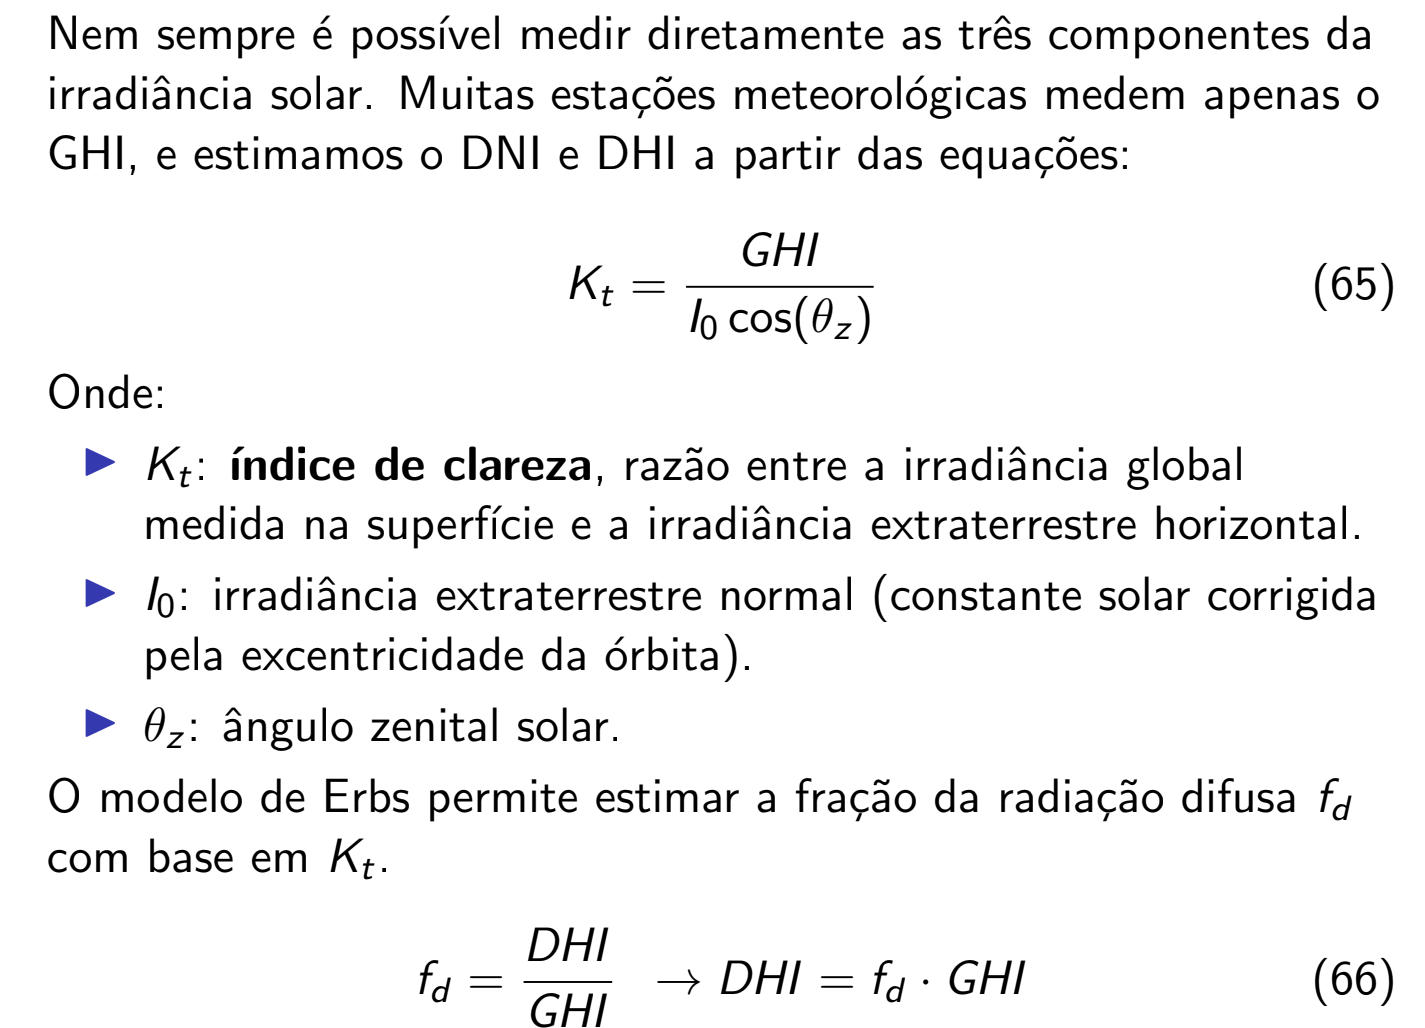


### **1.7.1.1 Gráfico: Fração Difusa (DHI / GHI) vs Kt (GHI / (H0*cos (θz)))**

###Relação entre Fração Difusa e Índice de Claridade Atmosférica  (Kt)**

**Fração Difusa = DHI / GHI**  
**Índice de Claridade Atmosférica  (Kt) = GHI / (H₀ × cos(θz))**

Onde:
- **H₀**: Irradiância extraterrestre no plano horizontal
- **θz**: Ângulo zenital solar

**Análise:**
- **Kt alto (> 0,6)**: Condições de céu claro → menor fração difusa
- **Kt baixo (< 0,3)**: Céu encoberto → maior fração difusa
- **Relação inversa** esperada entre Kt e fração difusa

> *“O índice de claridade atmosférica (Kt) é um indicador direto da predominância de componentes direta ou difusa.”* (LUNA, 2022, p. 17)


In [ ]:
# Kt x Diffuse Fraction
dni_extra = pvlib.irradiance.get_extra_radiation(df_weather.index)
Kt = df_weather['ghi']/dni_extra
diff_fraction = df_weather['dhi']/df_weather['ghi']

plt.scatter(Kt, diff_fraction)
plt.ylim(0, 1)
plt.xlabel('Kt (GHI/Io)')
plt.ylabel('Fração Difusa (DHI/GHI)')
plt.show()

### **1.7.2 Componentes do Recurso Solar na Horizontal vs Ângulo zenital**
Informa como a irradiância global na horizontal (GHI) varia com o ângulo zenital do Sol, ou seja, com a altura solar no céu. A irradiância é máxima quando o Sol está próximo do zênite (meio-dia) e diminui à medida que o Sol se aproxima do horizonte (ângulo zenital aumenta).

Tem a finalidade de visualizar o perfil diário do recurso solar, avaliar perdas geométricas em superfícies horizontais e determinar horários mais produtivos para sistemas FV.


In [ ]:
# @title


### **1.7.3 Inspeção Visual de Duas Dimensões (GHI, DNI e DHI)**
É um gráfico de dispersão ou mapa 2D que representa simultaneamente as componentes do recurso solar, GHI, DNI e DHI

Mostra a consistência ente os componentes e avalia a consistência e qualidade dos dados

### **1.6.5 Dados Solarimétricos Ano 2021**

Para modelagem foi escolhido os dados relativos a 2021 que apresentaram melhores resultados, conforme a métrica RMSE, em comparação com os dados de 2019 e 2020



* Componentes do recurso solar na horizontal vs ângulo zenital
* Inspeção visual de duas dimensões(GHI, DNI e DHI)



---

**Selecao de 1 ano para Análises**

Para modelagens que permitem uso de apenas um dos anos, os dados relativos a 2021 foram selecionados em razão do melhor resultado comparado ao RMSE para 2019 e 2020.

O Código seguinte apenas apresenta os dados solarimétricos, Temp. Amb. e Velocidade do vento para o ano de 2021:


In [ ]:
# @title
# Calculate annual and monthly averages for the specified parameters for 2021

# GHI from UAT station data 2021
ghi_uat_2021_annual = df_weather_2021['ghi'].sum()
ghi_uat_2021_monthly = df_weather_2021['ghi'].resample('M').sum()

# DNI modeled with Erbs using GHI_NRSDB_2021
dni_erbs_2021_annual = out_erbs['dni_erbs'].sum()
dni_erbs_2021_monthly = out_erbs['dni_erbs'].resample('M').sum()

# DHI modeled with Boland using GHI_NRSDB_2021
dhi_boland_2021_annual = out_boland['dhi_boland'].sum()
dhi_boland_2021_monthly = out_boland['dhi_boland'].resample('M').sum()

# Temp_amb from UAT station data 2021
temp_amb_uat_2021_annual = df_weather_2021['temp_air'].mean()
temp_amb_uat_2021_monthly = df_weather_2021['temp_air'].resample('M').mean()

# Wind_speed from UAT station data 2021
wind_speed_uat_2021_annual = df_weather_2021['wind_speed'].mean()
wind_speed_uat_2021_monthly = df_weather_2021['wind_speed'].resample('M').mean()

# Print annual values
print("--- Valor Anual (2021) ---")
print(f"GHI (UAT): {ghi_uat_2021_annual:.2f} Wh/m²")
print(f"DNI (Erbs - NSRDB): {dni_erbs_2021_annual:.2f} Wh/m²")
print(f"DHI (Boland - NSRDB): {dhi_boland_2021_annual:.2f} Wh/m²")
print(f"Temp Amb (UAT): {temp_amb_uat_2021_annual:.2f} °C")
print(f"Wind Speed (UAT): {wind_speed_uat_2021_annual:.2f} m/s")

# Print monthly averages
print("\n--- Médias Mensais (2021) ---")
print("\nGHI (UAT):")
print(ghi_uat_2021_monthly)
print("\nDNI (Erbs - NSRDB):")
print(dni_erbs_2021_monthly)
print("\nDHI (Boland - NSRDB):")
print(dhi_boland_2021_monthly)
print("\nTemp Amb (UAT):")
print(temp_amb_uat_2021_monthly)
print("\nWind Speed (UAT):")
print(wind_speed_uat_2021_monthly)

In [ ]:
# @title
#Importing the Weather Station Data for 2021
#Location of the University of Arizona (OASIS)

df_weather_2021 = pvlib.iotools.read_midc_raw_data_from_nrel('UAT',               # Station id
                                                    pd.Timestamp('20210101'),   # Start date jan 2021
                                                    pd.Timestamp('20211231'))   # End date dez 2021

# Rename columns to match expected names
df_weather_2021 = df_weather_2021.rename(columns={
    'Air Temperature [deg C]': 'temp_air',
    'Avg Wind Speed @ 3m [m/s]': 'wind_speed',
    'Diffuse Horiz [W/m^2]': 'dhi',
    'Direct Normal [W/m^2]': 'dni',
    'Global Horiz (platform) [W/m^2]': 'ghi'
})

In [ ]:
# @title
#Importing the Weather Station Data for 2021
#Location of the University of Arizona (OASIS)

df_weather_2021 = pvlib.iotools.read_midc_raw_data_from_nrel('UAT',               # Station id
                                                    pd.Timestamp('20210101'),   # Start date jan 2021
                                                    pd.Timestamp('20211231'))   # End date dez 2021

# Rename columns to match expected names
df_weather_2021 = df_weather_2021.rename(columns={
    'Air Temperature [deg C]': 'temp_air',
    'Avg Wind Speed @ 3m [m/s]': 'wind_speed',
    'Diffuse Horiz [W/m^2]': 'dhi',
    'Direct Normal [W/m^2]': 'dni',
    'Global Horiz (platform) [W/m^2]': 'ghi'
})



---



# **2. Modelagem da Usina Fotovoltaica**
O sistema fotovoltaico foi concebido e dimensionado para atingir uma potência de módulos FV monofaciais de 120 kW, instalados em solo.



## **2.1 Seleção de componentes**
Foram selecionados os seguintes equipamentos a partir da base de dados da PVlib

### **Módulo Fotovoltaico**

| Parâmetro                  | Valor                          |
|----------------------------|--------------------------------|
| Modelo                     | DM500M10RT-B60HBT/HST-U |
| Potência Nominal (STC)     | 500 W                     |
| Tensão em MPP (Vmp)        | 37,66 V                        |
| Tensão em Circuito Aberto (Voc) | 44,70 V                    |
| Corrente em MPP (Imp)      | 13,30 A                       |
| Corrente de Curto-Circuito (Isc) | 14,22 A                   |

### **Inversor**

| Parâmetro                  | Valor                          |
|----------------------------|--------------------------------|
| Modelo                     | Genérico do PVSyst |
| Potência unitária (CA)     | 80 kW                     |
| Tensão de funcionamento        | 405-750 V                        |


Para o projeto foi selecionado um inversor de **800 kW** que resulta em uma **relação DC/AC de** **1.24**, que apresenta as seguintes características:



## **2.1.1 Dimensionamento do sistema fotovoltaico**

### **Quantidade de Módulos**

- Potência por módulo: **500 W**
- Potência-alvo: **99.000 W**
- Módulos calculados:
  $$
  \frac{99.000}{500} \approx 198 \text{ módulos}
  $$



#**AOI** - Angle of Incidence - Ângulo de Incidência

In [ ]:
# @title Texto de título padrão
# --------------------------------------------
# 1) Definições do local e horário
# --------------------------------------------
latitude = 32.22969
longitude = -110.95534
tz = 'Etc/GMT-7'  # Fuso horário local correto

# Coordenadas geográficas (latitude, longitude, altitude) de UAT

altitude = 786  # em metros
# Ângulos da superfície
tilt = 33                      # Inclinação do painel (graus)
surface_azimuth = 180          # Sul (180°)

# --------------------------------------------
# 2) AOI para um instante específico
# --------------------------------------------
date = pd.Timestamp('2021-01-01 10:30:00', tz=tz)

# Calcula a posição solar
solar_position = pvlib.solarposition.get_solarposition(time=date,
                                                       latitude=latitude,
                                                       longitude=longitude)

# Calcula o Ângulo de Incidência (AOI)
aoi = pvlib.irradiance.aoi(surface_tilt=tilt,
                           surface_azimuth=surface_azimuth,
                           solar_zenith=solar_position['zenith'],
                           solar_azimuth=solar_position['azimuth'])

# Exibe os resultados
aoi_deg = aoi.iloc[0]  # valor numérico do AOI
print("AOI (instantâneo):", round(aoi_deg, 2), "graus")
print(aoi)             # mostra também com índice temporal

In [ ]:


start = '2019-01-01'
end = '2021-12-31'

#Vamos variar o AOI ao longo do dia
site = location.Location(latitude, longitude, tz=tz)
times = pd.date_range(start, end, freq='1D', tz=site.tz)

# Ângulos da superfície
tilt = 33  # inclinação da superfície
surface_azimuth = 180   #  graus oeste do sul (Sul é 180 graus)

# Calcula a posição solar
solar_position = pvlib.solarposition.get_solarposition(time=times, latitude=latitude, longitude=longitude)

# Calcula o ângulo de incidência
aoi = pvlib.irradiance.aoi(surface_tilt=tilt,
                           surface_azimuth=surface_azimuth,
                           solar_zenith=solar_position['zenith'],
                           solar_azimuth=solar_position['azimuth'])

aoi.plot(figsize=(20,6))


plt.title('Ângulo de Incidência (AOI) ao longo do ano - UAT')
plt.ylabel('aoi [graus]')
plt.xlabel('Data')
plt.grid(True)
plt.legend()
plt.show()

# **IAM**

In [ ]:
#3. Calcula o fator de perda por ângulo de incidência
iam = pvlib.iam.physical(aoi)
print(iam)